<a href="https://colab.research.google.com/github/Darian-Lee-YTKA/mice_neuron_data_ml/blob/main/older_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install rpy2

# Importing the data and converting from nested R lists to a data type native to python. Since the nested lists have different lengths, I will use a dictionary for now

In [2]:
import pandas as pd
from rpy2.robjects import pandas2ri

In [3]:
import rpy2.robjects as robjects
rdata = robjects.r['readRDS']('/content/session1.rds')

In [4]:
rdata1 = robjects.r['readRDS']('/content/session1.rds')


rdata2 = robjects.r['readRDS']('/content/session2.rds')


rdata3 = robjects.r['readRDS']('/content/session3.rds')


rdata4 = robjects.r['readRDS']('/content/session4.rds')


rdata5 = robjects.r['readRDS']('/content/session5.rds')


rdata6 = robjects.r['readRDS']('/content/session6.rds')


rdata7 = robjects.r['readRDS']('/content/session7.rds')


rdata8 = robjects.r['readRDS']('/content/session8.rds')


rdata9 = robjects.r['readRDS']('/content/session9.rds')


rdata10 = robjects.r['readRDS']('/content/session10.rds')


rdata11 = robjects.r['readRDS']('/content/session11.rds')


rdata12 = robjects.r['readRDS']('/content/session12.rds')


rdata13 = robjects.r['readRDS']('/content/session13.rds')


rdata14 = robjects.r['readRDS']('/content/session14.rds')


rdata15 = robjects.r['readRDS']('/content/session15.rds')


rdata16 = robjects.r['readRDS']('/content/session16.rds')


rdata17 = robjects.r['readRDS']('/content/session17.rds')


rdata18 = robjects.r['readRDS']('/content/session18.rds')


In [5]:
for name in rdata1.names:
    print(name)
    print(len(rdata1.rx2(name)))


contrast_left
114
contrast_right
114
feedback_type
114
mouse_name
1
brain_area
734
date_exp
1
spks
114
time
114


It seems like each of these sessions represent the measurements for 1 specific session. The mice are repeated accross sessions. I will explore the data a bit more for session1 with Cori.

In [6]:

import numpy as np
spks_data = rdata1.rx2('spks')

spks_array = np.array(spks_data)
spks_array.shape

# after analysing the data in R and talking to the professor, it seems that the
# 114 is the number of neurons, the 40 is the time, and the 734 is the brain area

trial1 = np.squeeze(spks_array[[0]]) # will get rid of 1 dimnesion
print(trial1.shape)
print(trial1[300].shape)
print(trial1[ :,3].shape)

# ok this make sense to me. We have 114 trials in each session. Each trial contains data from 114 neurons over 40 time intervals

(734, 40)
(40,)
(734,)


My idea is to have one column for each time stamp with the matrix at that time.

In [7]:
import numpy as np

Since the matrices represent the neurons at each time stamp for .4 seconds with no changes in stimuli, it makes sense to find the average across each row.

In [8]:
import matplotlib.pyplot as plt

class Neuron_instance:
  # a neuron in a specific trial situation
  def __init__(self, data, brain_area, kind, mother, session_id):
    self.data = data
    self.session_id = session_id # so that we can match up neurons across trials
    self.cluster = None
    self.brain_area = brain_area
    self.kind = kind
    #in case I need to go from neuron back to trial
    self.mother = mother
  def set_cluster(self, cluster):
    self.cluster = cluster



class Trial:
  def __init__(self, feedback, contrast_left, contrast_right, data, brain_area, mother, trial_id):
    self.data = data
    self.kind = None # for which contrast is higher and whether it was correct or incorrect
    self.full_kind = None # full kind including exact contrast values. I will only include it for true values because they will be more useful for clustering
    if feedback == 1:
      self.full_kind = [contrast_left, contrast_right] # remember, left comes first
    self.neurons = []

    # I don't expect most of the following attributes to be used. They are mainly included for debugging
    self.feedback = feedback
    self.cl = contrast_left
    self.cr = contrast_right

    # in case I need to go from a trial back to the session
    self.mother = mother

    # this will come in handy when I make my dataframe
    self.trial_id = trial_id

    # to set kind (kind is based on the kind of stimuli and feedback)
    if contrast_left > contrast_right:
      if feedback == 1:
        self.kind = "left true"
      else:
        self.kind = "left false"
    elif contrast_right > contrast_left:
      if feedback == 1:
        self.kind = "right true"
      else:
        self.kind = "right false"
    else:
      self.kind = "equal true"

    # to set the neurons (rows)
    counter = 0
    for row in data:
      self.neurons.append(Neuron_instance(row, brain_area[counter], self.kind, self, counter))
      counter += 1



  # for my own use when inspecting the data
  def plot_self(self):
      plt.imshow(self.data, aspect='auto', cmap='hot')
      plt.colorbar(label='Activity')
      string = "kind: " + self.kind
      plt.title(string)
      plt.show()







# after analysing the data in R and talking to the professor, it seems that the
# 114 is the number of neurons, the 40 is the time, and the 734 is the brain area

trial1 = np.squeeze(spks_array[[0]]) # will get rid of 1 dimnesion
print(trial1.shape)
print(trial1[300].shape)
print(trial1[ :,3].shape)

class Session:
  def __init__(self, matrix, feedback, contrast_left, contrast_right, index, brain_area):
    self.matrix = np.array(matrix)
    self.trials = []
    self.name = "sesh" + str(index)
    # I'm not sure if this will be important, but I'll include it just incase
    self.brain_area = list(brain_area)

    for trial_index in range(self.matrix.shape[0]):
      current_trial = np.squeeze(self.matrix[[trial_index]])
      current_feedback = feedback[trial_index]
      current_CL = contrast_left[trial_index]
      current_CR = contrast_right[trial_index]
      temp_trial = Trial(current_feedback, current_CL, current_CR, current_trial, self.brain_area, self, self.name + "_" + str(trial_index))
      self.trials.append(temp_trial)

  def get_trial_full_kinds(self, query): # returns all trials in that session matching certain properties
    return [trial for trial in self.trials if trial.full_kind == query]

  def get_trial_kinds(self, query): # returns all trials in that session matching certain properties (which contrast is higher and true false)
    return [trial for trial in self.trials ]







(734, 40)
(40,)
(734,)


In [9]:
# just testing the code on one session
session1 = Session(rdata1.rx2('spks'), rdata1.rx2('feedback_type'), rdata1.rx2('contrast_left'), rdata1.rx2('contrast_right'), 1, rdata1.rx2('brain_area'))

In [10]:
print(session1.trials[1].neurons[1].data.shape)
print(session1.trials[1].neurons[1].data)

(40,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
len(session1.brain_area)

734

In [12]:
brain_areas = []
for neuron in session1.trials[0].neurons:
  brain_areas.append(neuron.brain_area)
print(len(brain_areas))


734


This is unexpected. It seems the number of neurons measured does not directly match up with the number of brain_areas

In [13]:
session1.matrix
print(session1.trials[7].data.shape) # working as expected

print(session1.trials[7].kind) # working as expected
print(session1.trials[7].neurons[1].mother.mother.name) # should return sesh1. Working as expected

print(session1.trials[0].neurons[0].brain_area) # the brain area of the first node from the first trial of the first session
print(session1.trials[0].neurons[1].brain_area) # the brain area of the second node from the first trial of the first session
print(len(session1.get_trial_full_kinds([.5,.25])))

# this should equal the total number of trials of type "right true"
# note this is because if the mouse got it wrong, trial.full_kind is None
print(len(session1.get_trial_full_kinds([0,.25]))+ len(session1.get_trial_full_kinds([0,.5])) + len(session1.get_trial_full_kinds([0,1]))+len(session1.get_trial_full_kinds([.25,.5])) + len(session1.get_trial_full_kinds([.25,1]))+ len(session1.get_trial_full_kinds([.5,1])))
print(len(session1.get_trial_kinds("right true")))

# nice!

(734, 40)
left true
sesh1
ACA
MOs
4
27
114


In [14]:
session1.matrix.shape

(114, 734, 40)

In [15]:
print(rdata1.rx2("mouse_name"))

[1] "Cori"



In [16]:
sessions = []
for i in range(1,19):
  rdata_instance = globals().get(f'rdata{i}')
  data = rdata_instance.rx2
  print(data("mouse_name")) # just to test that my code is getting the correct data
  temp_sesh = Session(data('spks'), data('feedback_type'), data('contrast_left'), data('contrast_right'), i, data('brain_area'))
  sessions.append(temp_sesh)



[1] "Cori"

[1] "Cori"

[1] "Cori"

[1] "Forssmann"

[1] "Forssmann"

[1] "Forssmann"

[1] "Forssmann"

[1] "Hench"

[1] "Hench"

[1] "Hench"

[1] "Hench"

[1] "Lederberg"

[1] "Lederberg"

[1] "Lederberg"

[1] "Lederberg"

[1] "Lederberg"

[1] "Lederberg"

[1] "Lederberg"



In [17]:
for session in sessions:
  print("\n\n\n\n new sesh just dropped")
  print(len(session.brain_area))
  brain_areas = []

  for neuron in session.trials[0].neurons:
    brain_areas.append(neuron.brain_area)
  print(len(brain_areas))





 new sesh just dropped
734
734




 new sesh just dropped
1070
1070




 new sesh just dropped
619
619




 new sesh just dropped
1769
1769




 new sesh just dropped
1077
1077




 new sesh just dropped
1169
1169




 new sesh just dropped
584
584




 new sesh just dropped
1157
1157




 new sesh just dropped
788
788




 new sesh just dropped
1172
1172




 new sesh just dropped
857
857




 new sesh just dropped
698
698




 new sesh just dropped
983
983




 new sesh just dropped
756
756




 new sesh just dropped
743
743




 new sesh just dropped
474
474




 new sesh just dropped
565
565




 new sesh just dropped
1090
1090


In [18]:
# to see if the brian areas are consistant across sessions
all_brian_areas = []
for session in sessions:
  brian_areas = list(session.brain_area)
  all_brian_areas.extend(brian_areas)

unique_brian_areas = set(all_brian_areas)
unique_brian_areas = list(unique_brian_areas)
print(len(unique_brian_areas))
print(unique_brian_areas[:10], "\n", print(unique_brian_areas[10:20]), "\n", print(unique_brian_areas[20:30]), "\n", print(unique_brian_areas[30:40]), "\n", print(unique_brian_areas[40:50]), "\n", print(unique_brian_areas[50:60]))



62
['LS', 'POL', 'CA1', 'SCs', 'SSp', 'EPd', 'AUD', 'LSc', 'MEA', 'ACB']
['VISa', 'VPL', 'SSs', 'MG', 'VISam', 'DG', 'LD', 'MS', 'ZI', 'RN']
['PL', 'MB', 'LH', 'BLA', 'VISpm', 'ACA', 'VISrl', 'RSP', 'TT', 'OT']
['CA3', 'root', 'VPM', 'NB', 'LGd', 'TH', 'MOs', 'POST', 'VISp', 'MRN']
['SCsg', 'LSr', 'ILA', 'PT', 'MD', 'PAG', 'SI', 'PO', 'RT', 'PIR']
['SPF', 'CP', 'MOp', 'SUB', 'VISl', 'ORBm', 'GPe', 'SCm', 'SNr', 'LP'] 
 None 
 None 
 None 
 None 
 None


I think the brain areas may be able to tell us something useful. At the very least, they can clue us into how many clusters we might need

In [19]:
for session in sessions:
  print("\n\n\n\n new sesh just dropped")
  for neuron in session.trials[0].neurons[:5]:
    print(neuron.brain_area)





 new sesh just dropped
ACA
MOs
ACA
LS
MOs




 new sesh just dropped
CA1
VISl
root
root
CA1




 new sesh just dropped
DG
VISam
MG
VISam
VISam




 new sesh just dropped
LGd
DG
TH
LGd
LGd




 new sesh just dropped
VISa
VISa
root
root
VISa




 new sesh just dropped
AUD
AUD
AUD
root
root




 new sesh just dropped
VPL
root
CA3
VPL
VPL




 new sesh just dropped
ILA
TT
ILA
MOs
ILA




 new sesh just dropped
TT
ORBm
TT
ORBm
ORBm




 new sesh just dropped
MB
MB
VISp
MB
MB




 new sesh just dropped
MOp
MOp
LSc
MOp
MOp




 new sesh just dropped
VISp
VISp
VISp
DG
VISp




 new sesh just dropped
VISam
VISam
ZI
DG
DG




 new sesh just dropped
ORB
MOs
ORB
MOs
ORB




 new sesh just dropped
BLA
BLA
GPe
BLA
BLA




 new sesh just dropped
SSs
SSs
SSs
SSs
SSs




 new sesh just dropped
root
root
VPL
root
root




 new sesh just dropped
CP
CP
CP
ACB
ACB


I do not fully understand how this data is organized, so I will procede using clustering and then perhaps compare the clustered data to these labels

sesh1


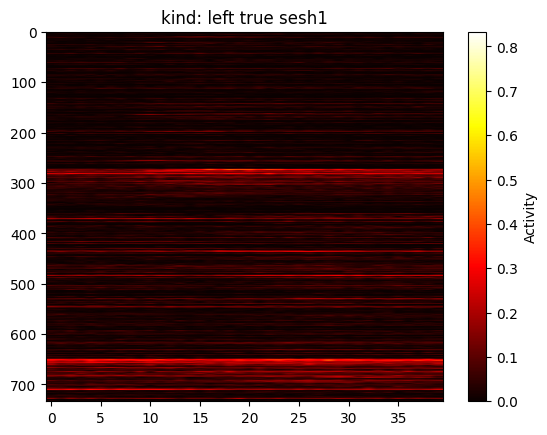

sesh1


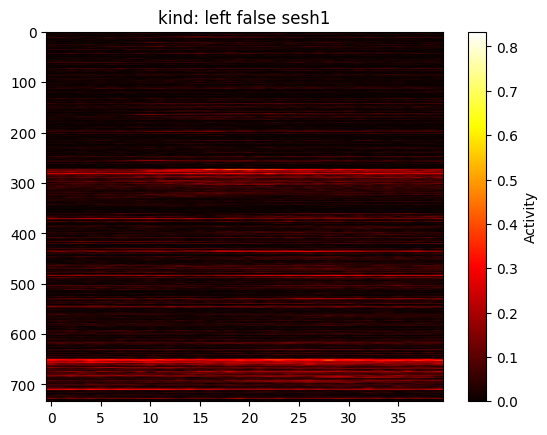

sesh1


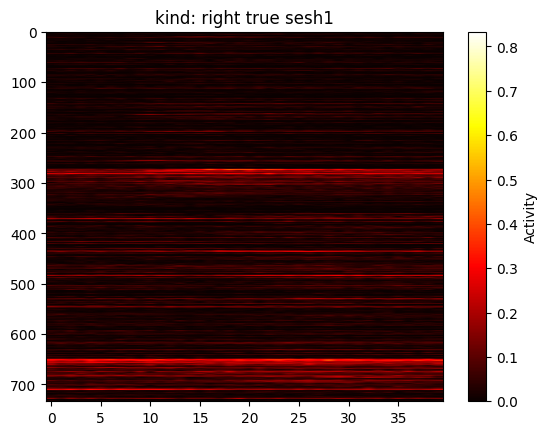

sesh1


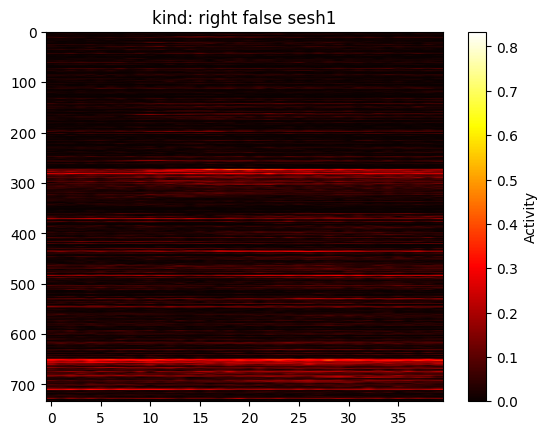

sesh1


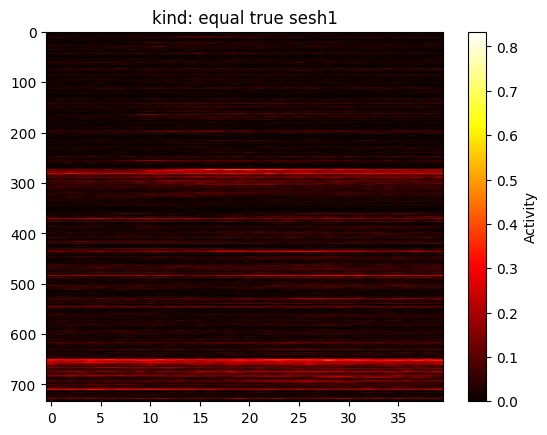

sesh2


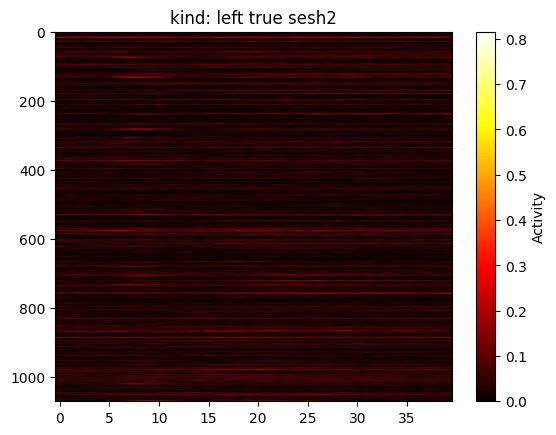

sesh2


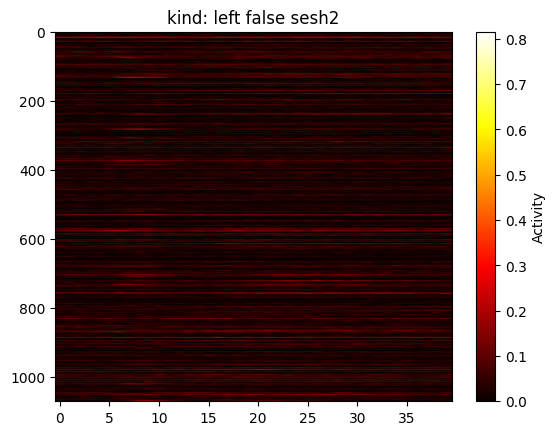

sesh2


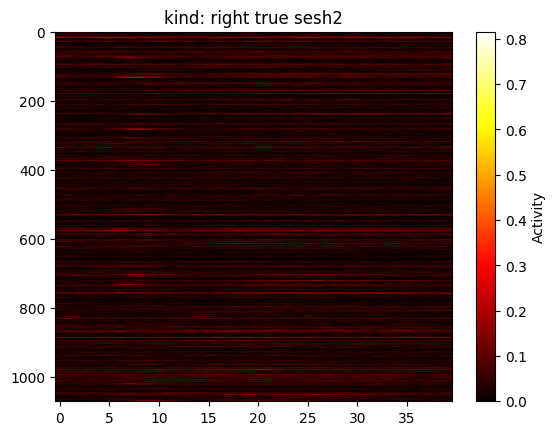

sesh2


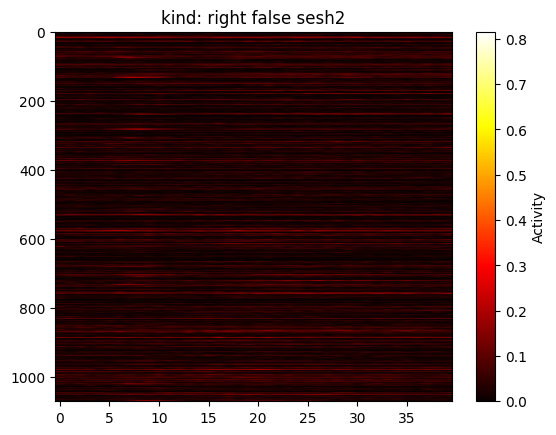

sesh2


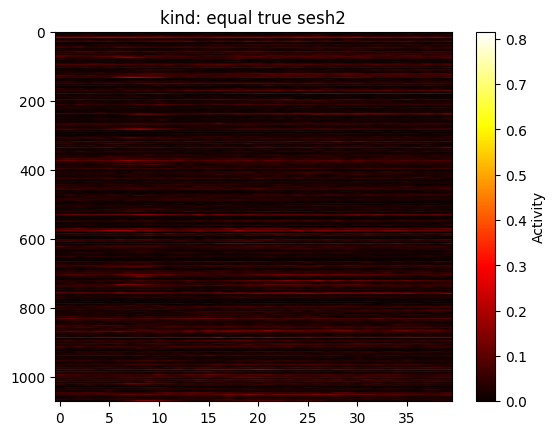

sesh3


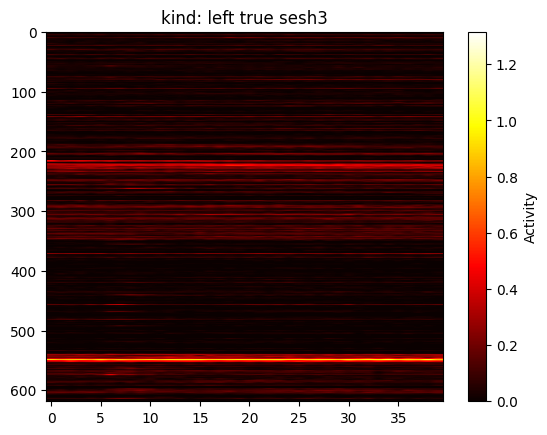

sesh3


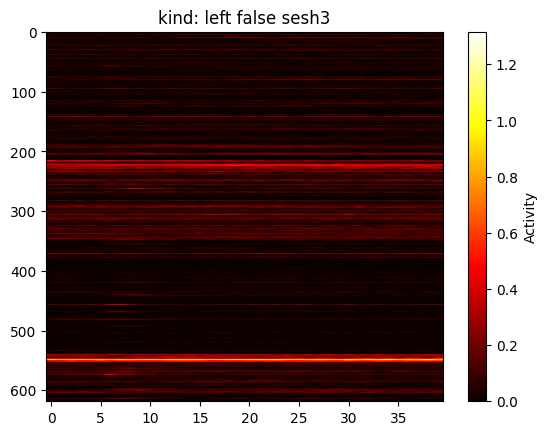

sesh3


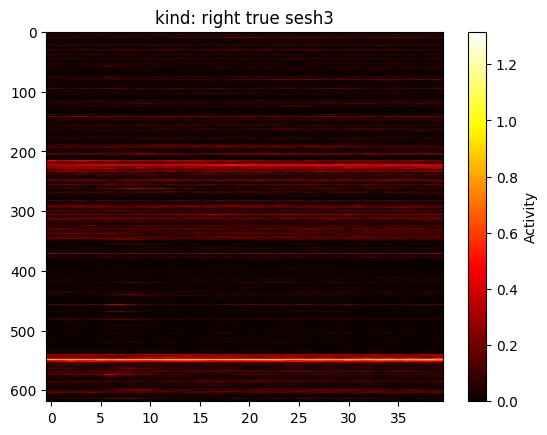

sesh3


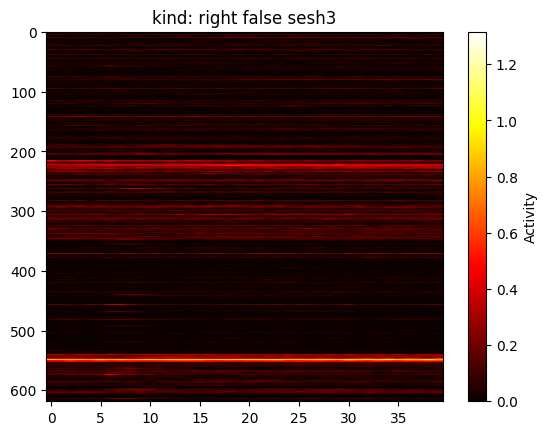

sesh3


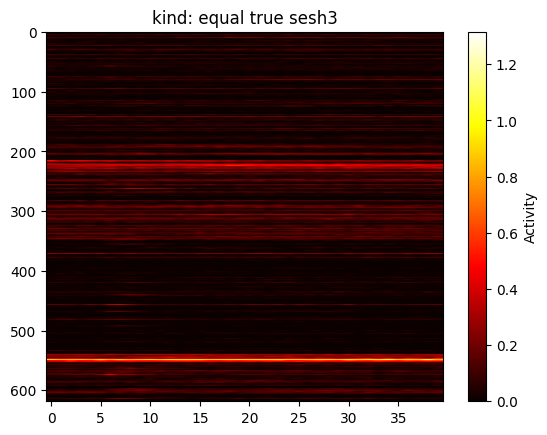

sesh4


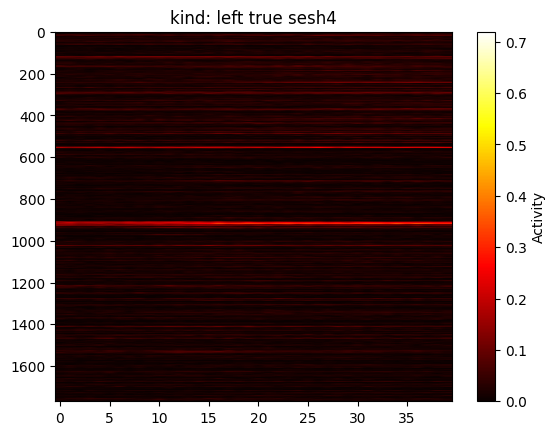

sesh4


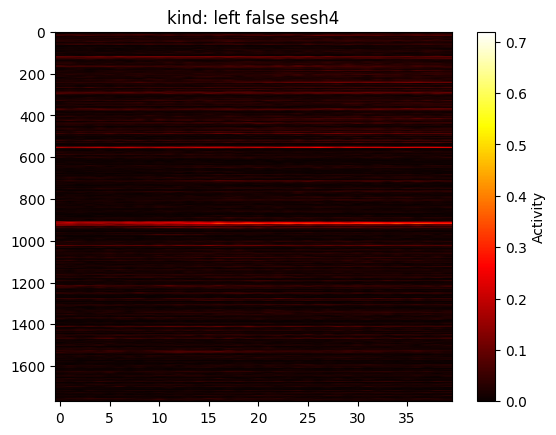

sesh4


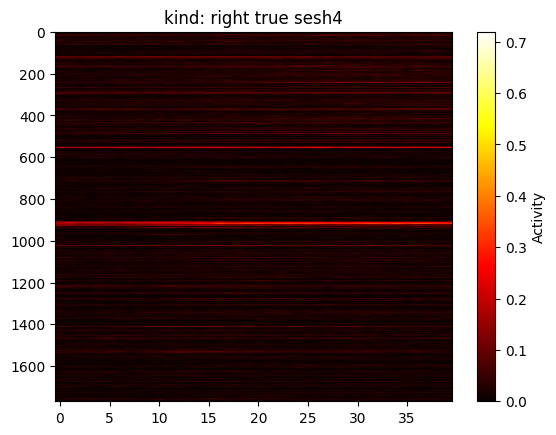

sesh4


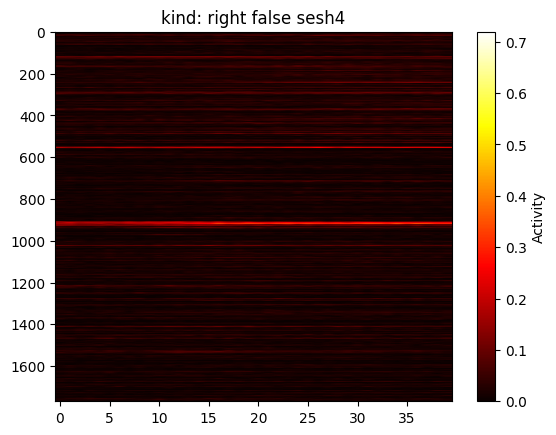

sesh4


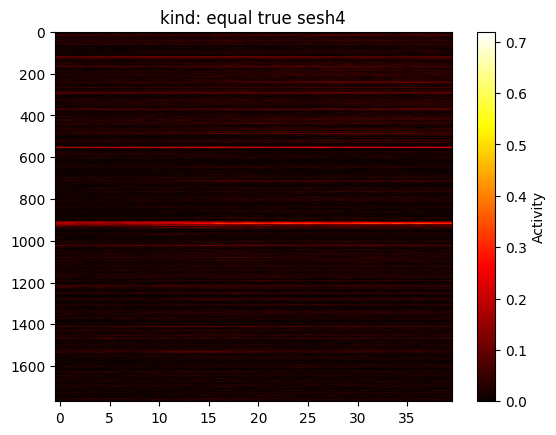

sesh5


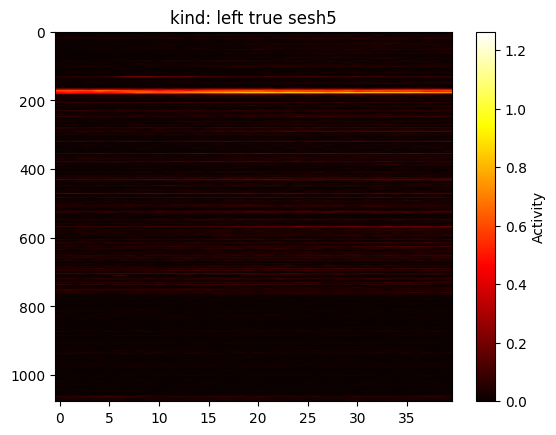

sesh5


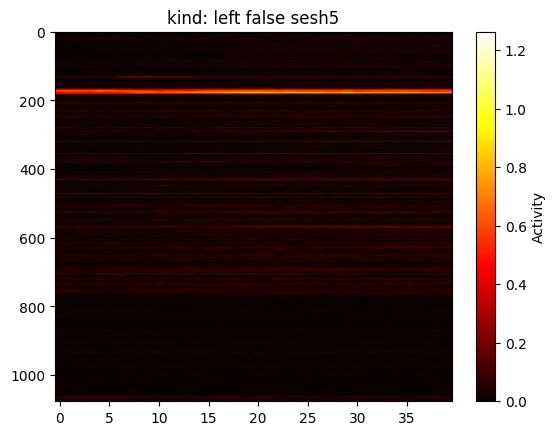

sesh5


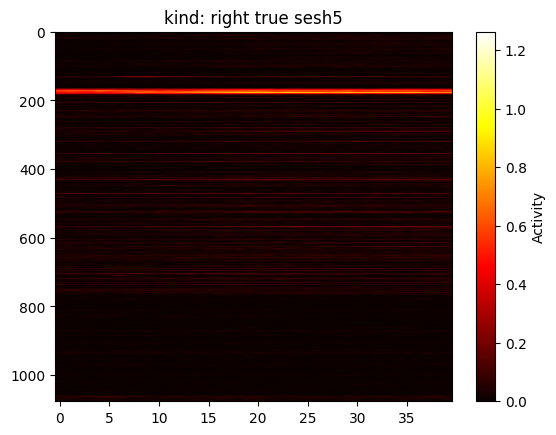

sesh5


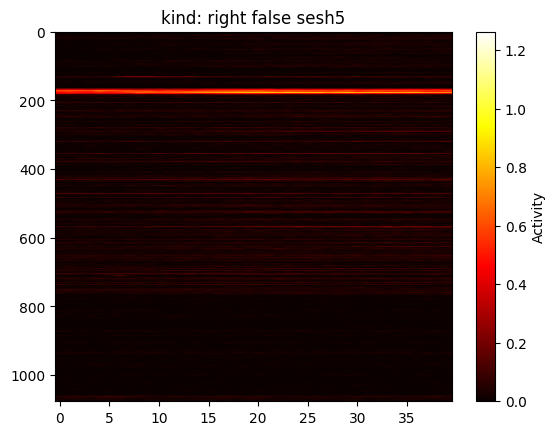

sesh5


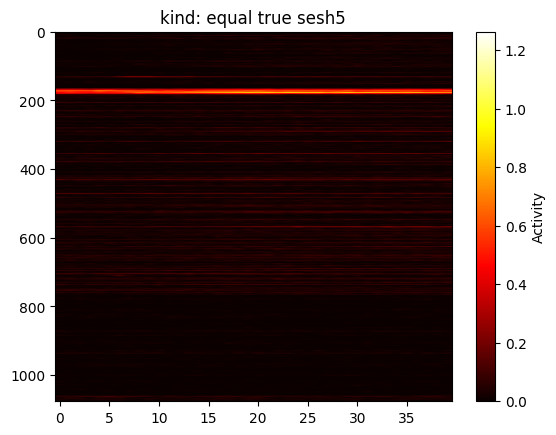

sesh6


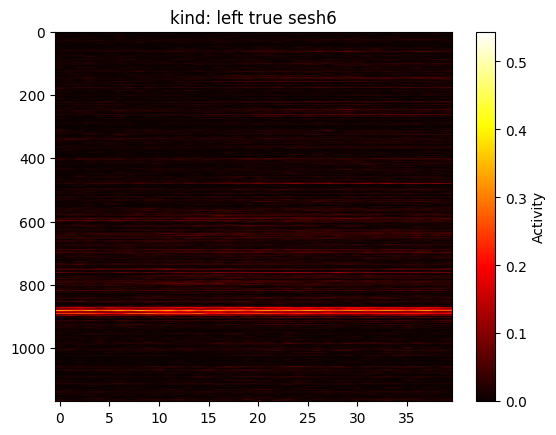

sesh6


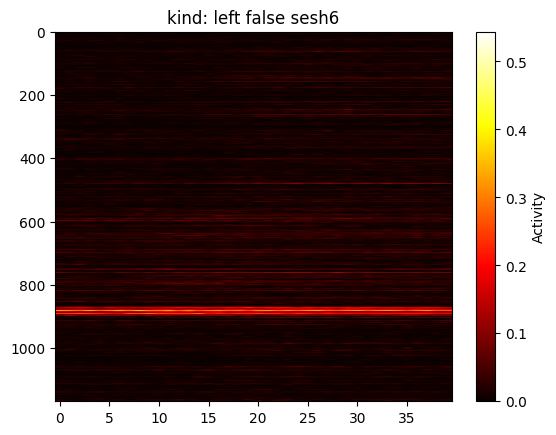

sesh6


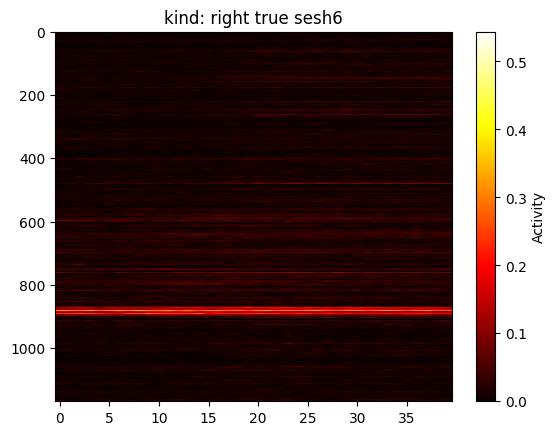

sesh6


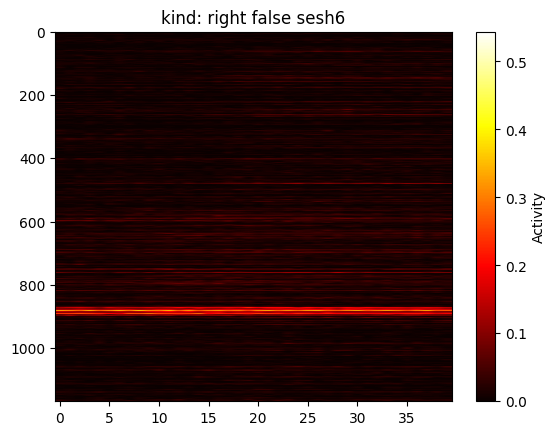

sesh6


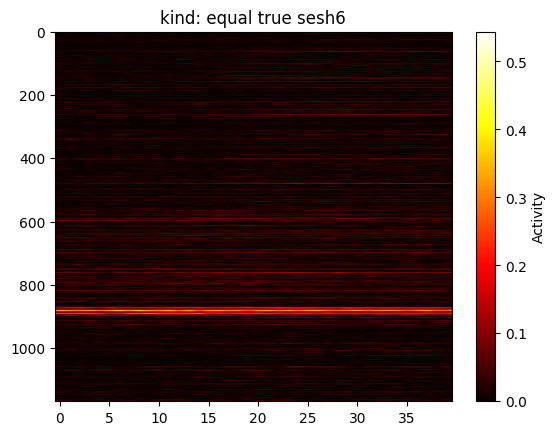

sesh7


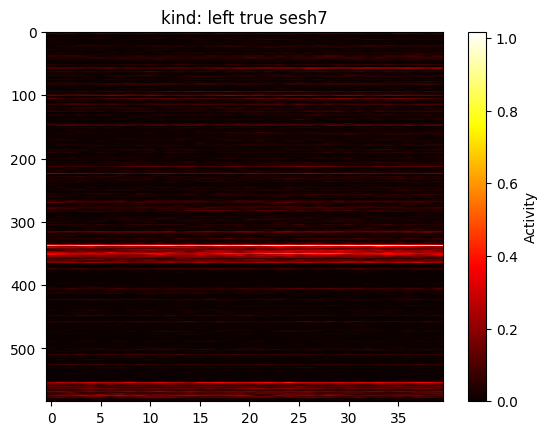

sesh7


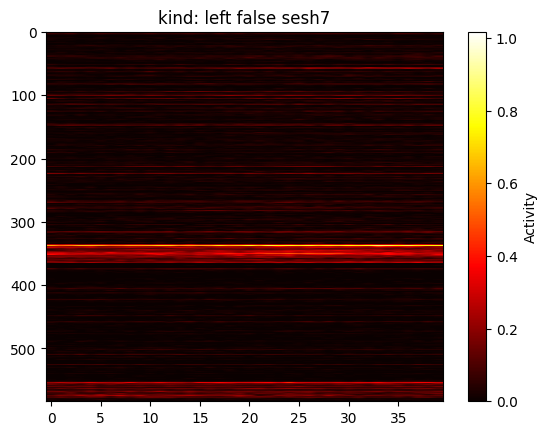

sesh7


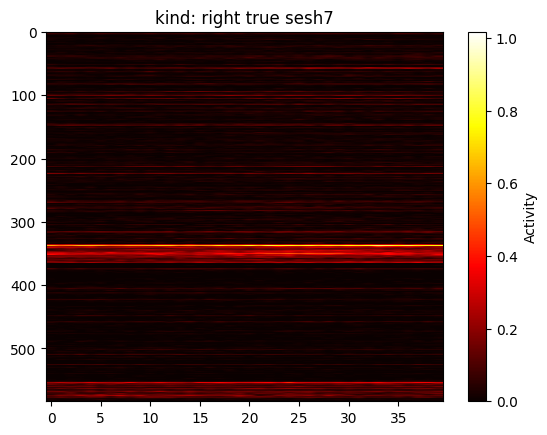

sesh7


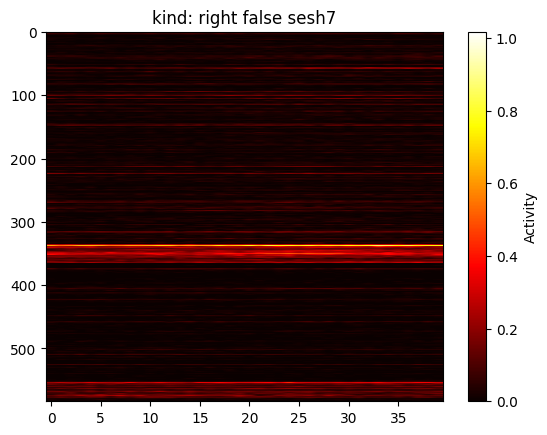

sesh7


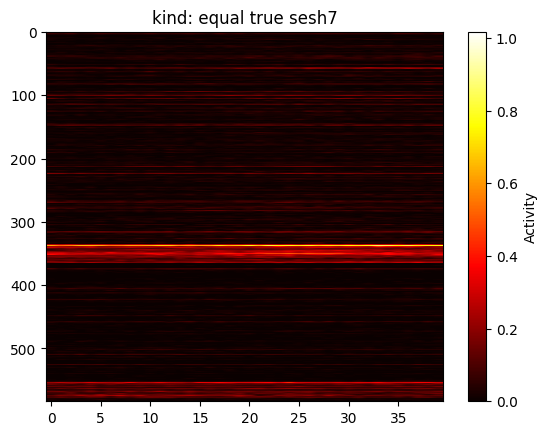

sesh8


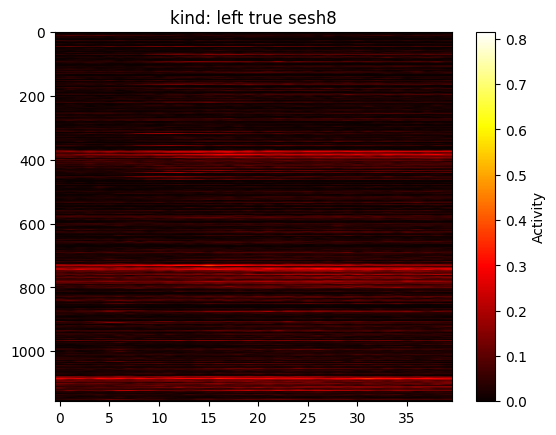

sesh8


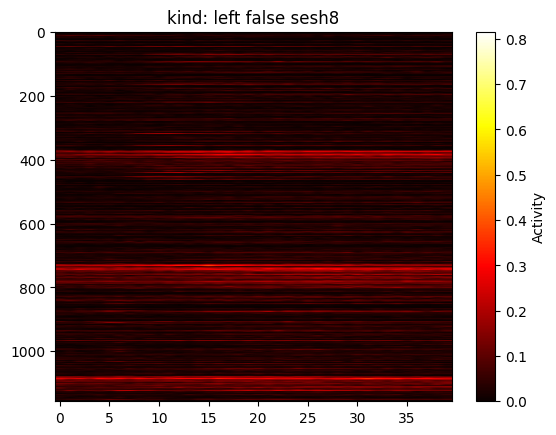

sesh8


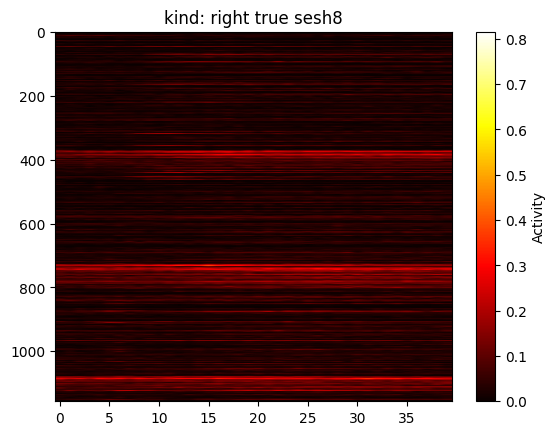

sesh8


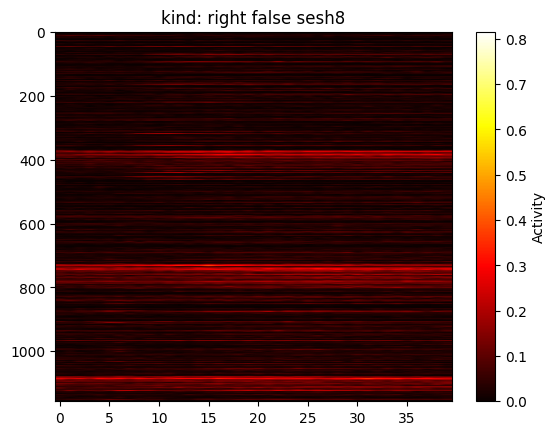

sesh8


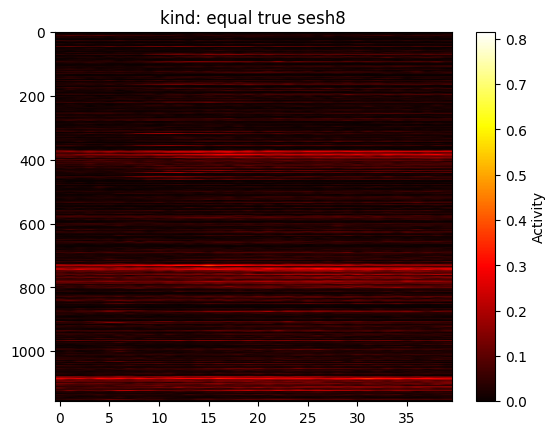

sesh9


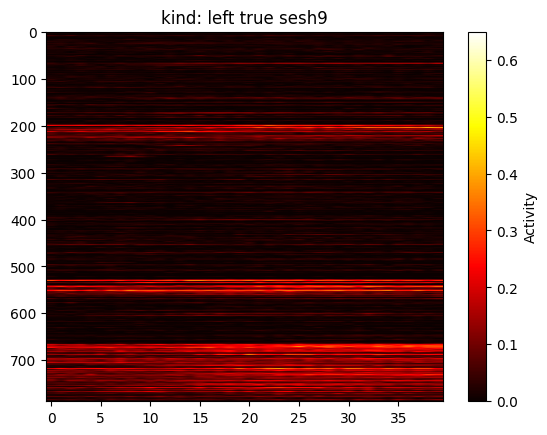

sesh9


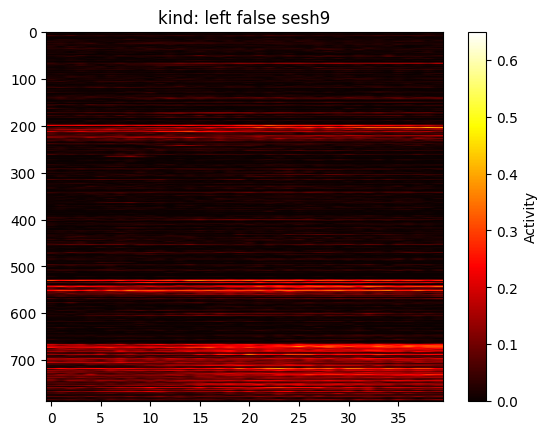

sesh9


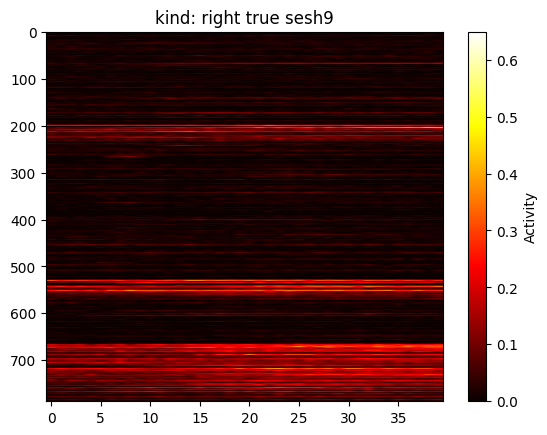

sesh9


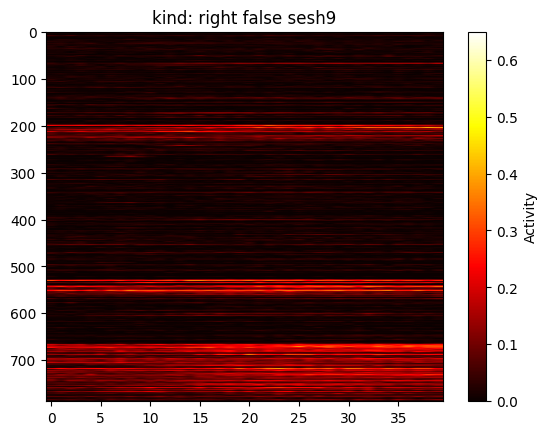

sesh9


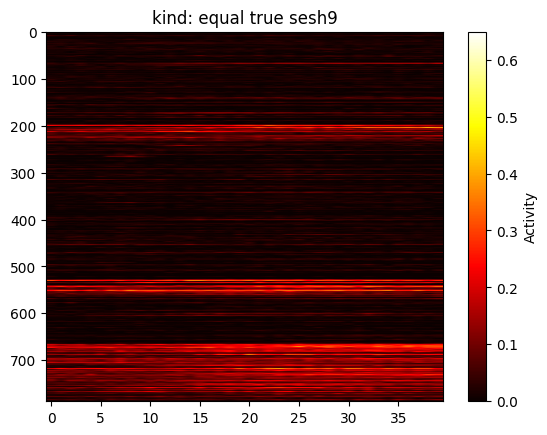

sesh10


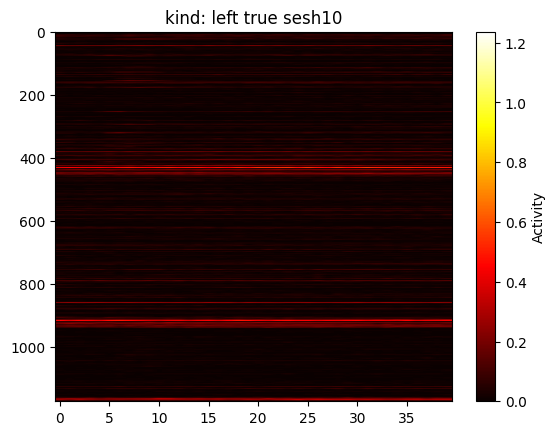

sesh10


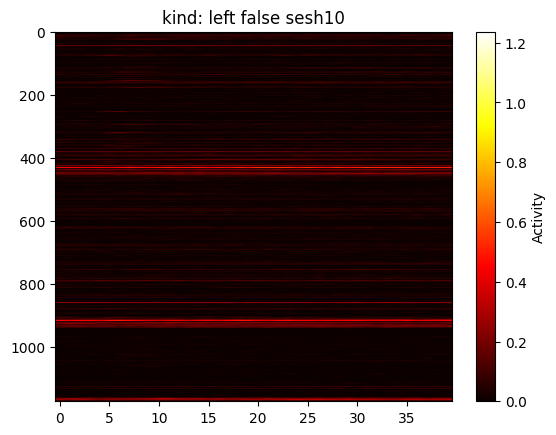

sesh10


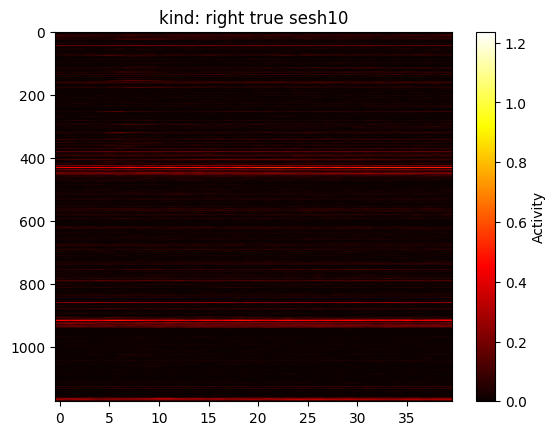

sesh10


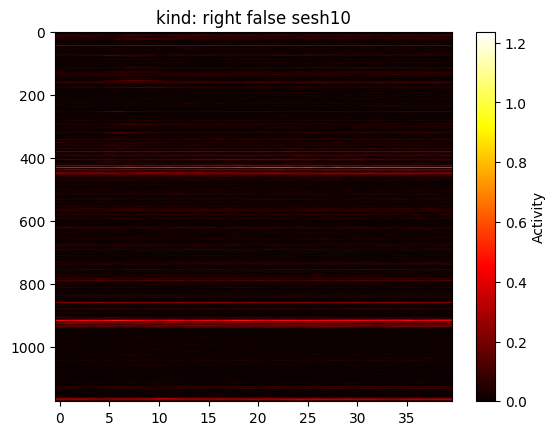

sesh10


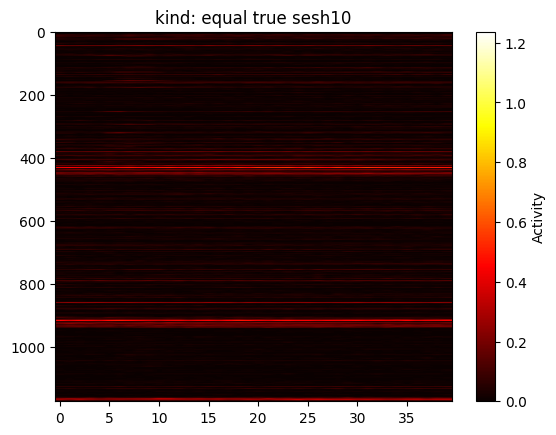

sesh11


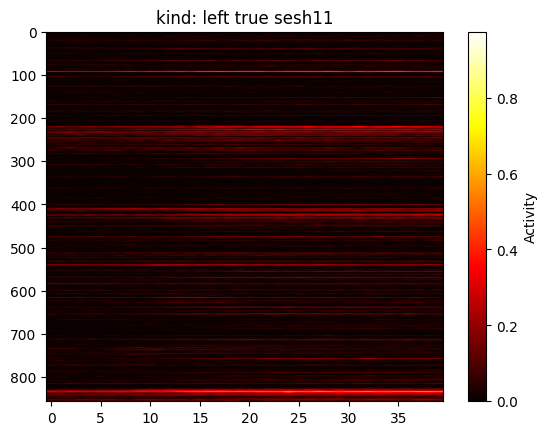

sesh11


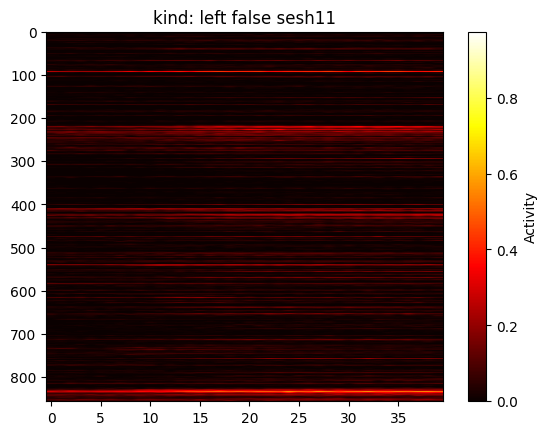

sesh11


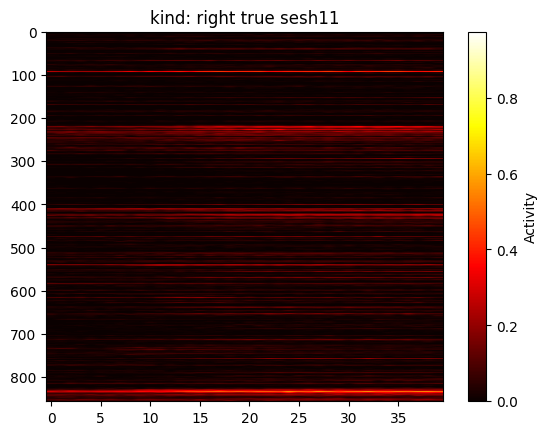

sesh11


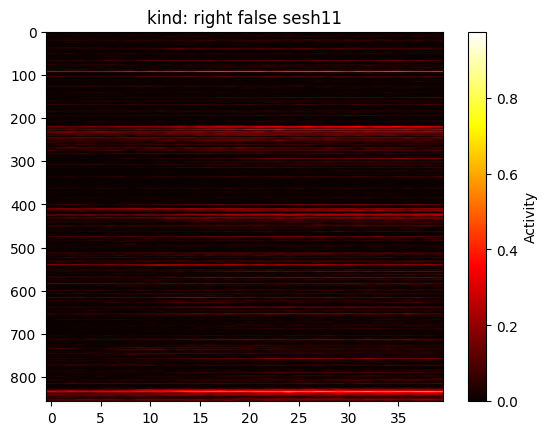

sesh11


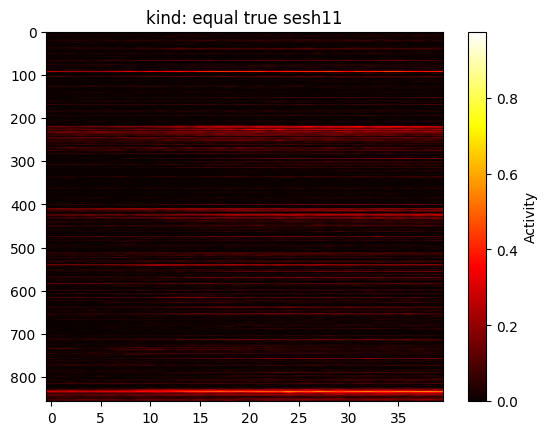

sesh12


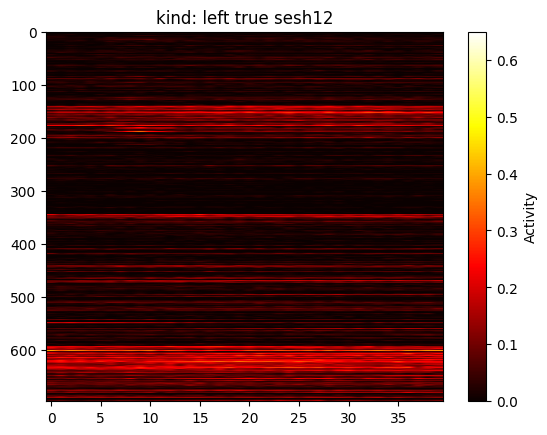

sesh12


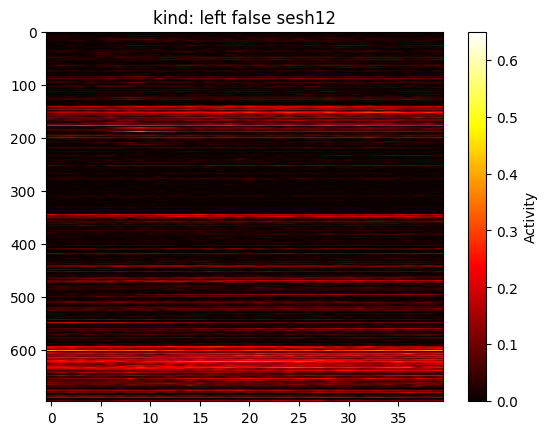

sesh12


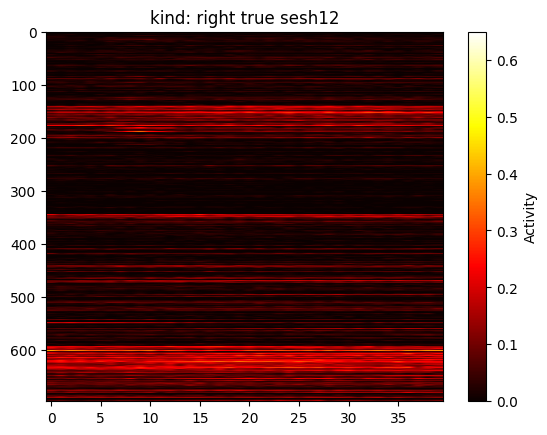

sesh12


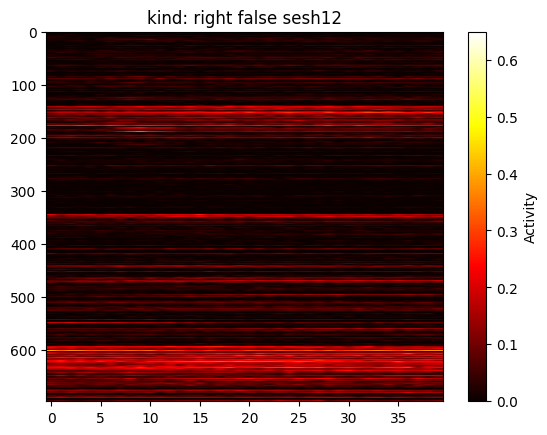

sesh12


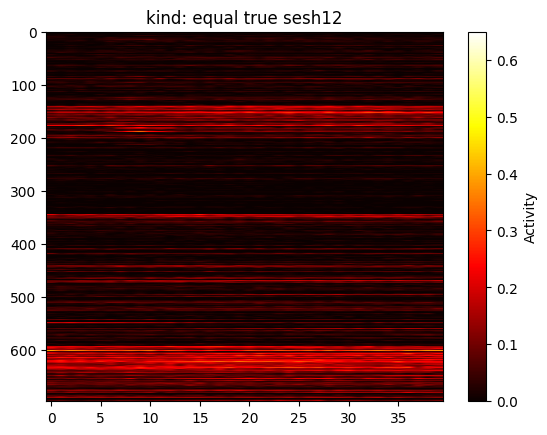

sesh13


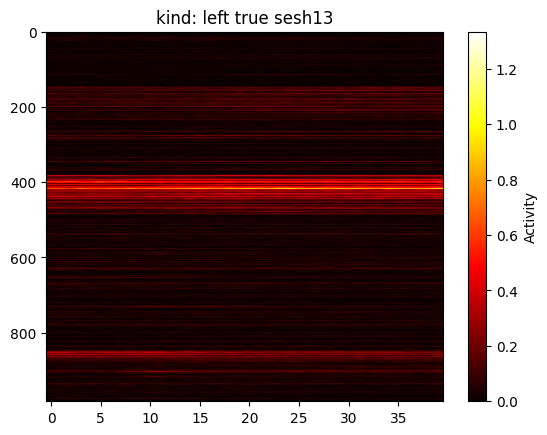

sesh13


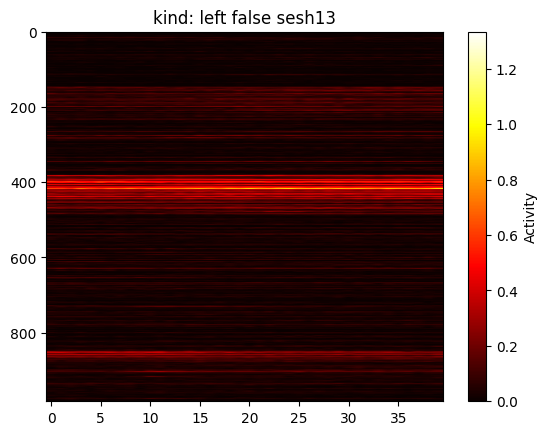

sesh13


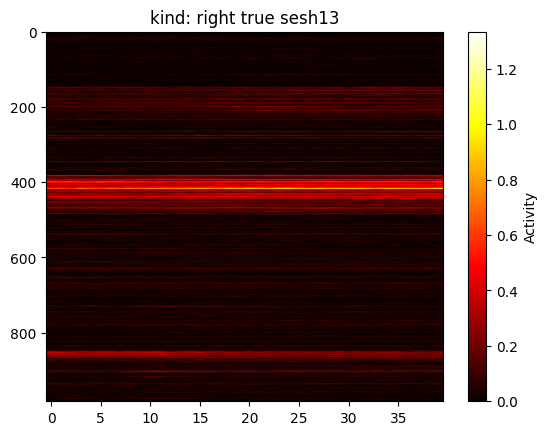

sesh13


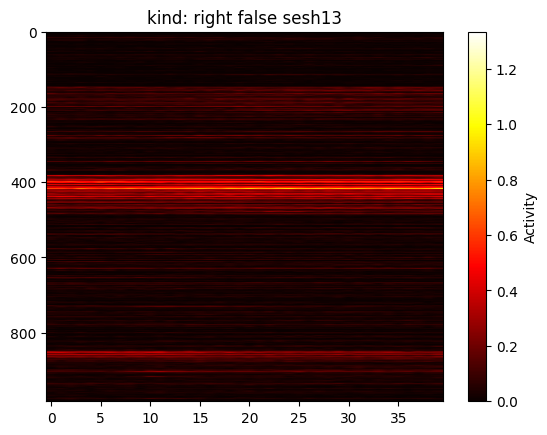

sesh13


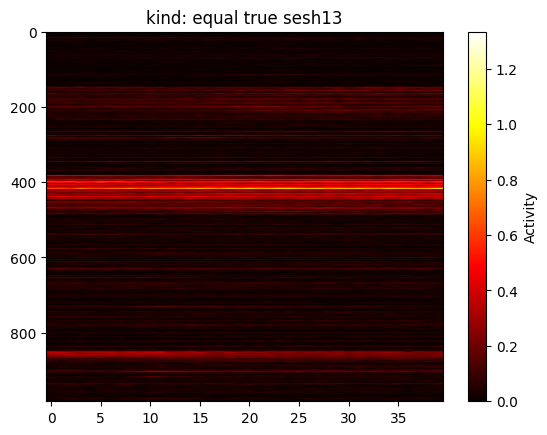

sesh14


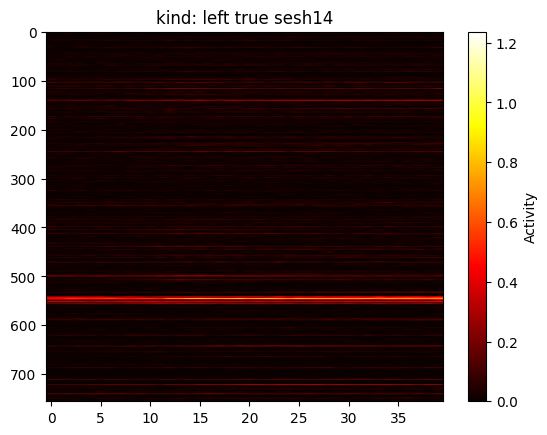

sesh14


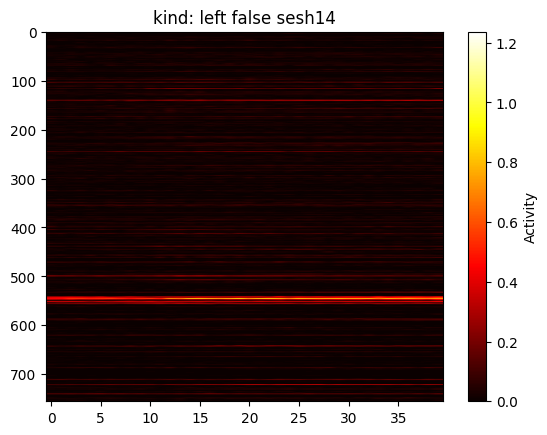

sesh14


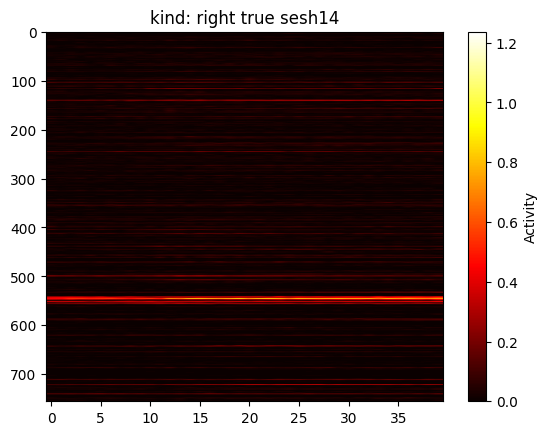

sesh14


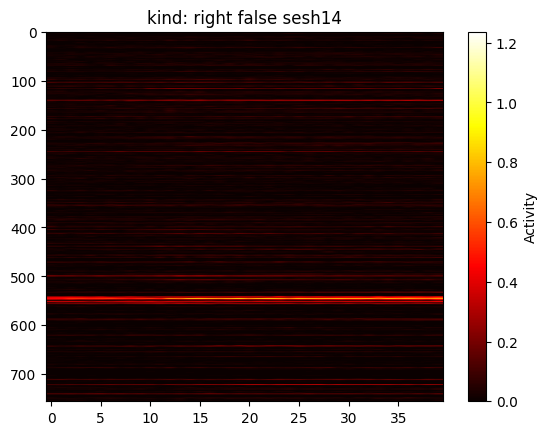

sesh14


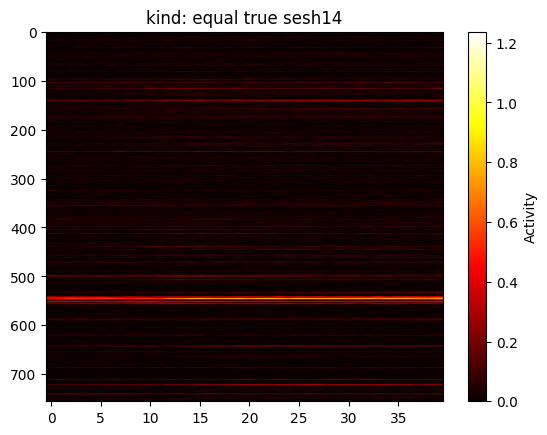

sesh15


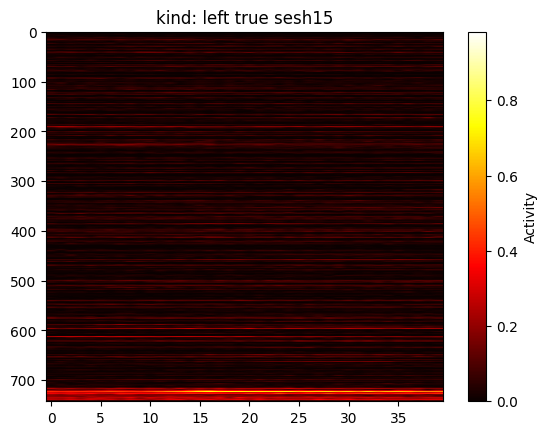

sesh15


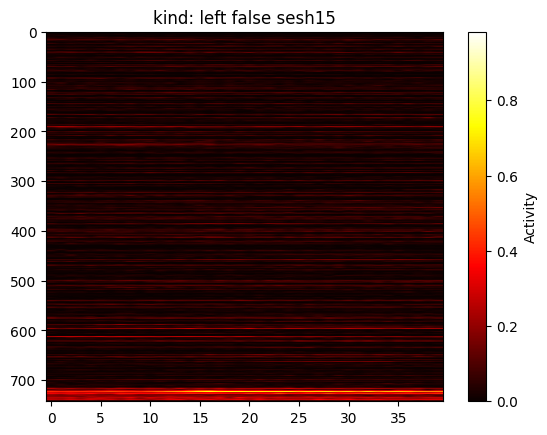

sesh15


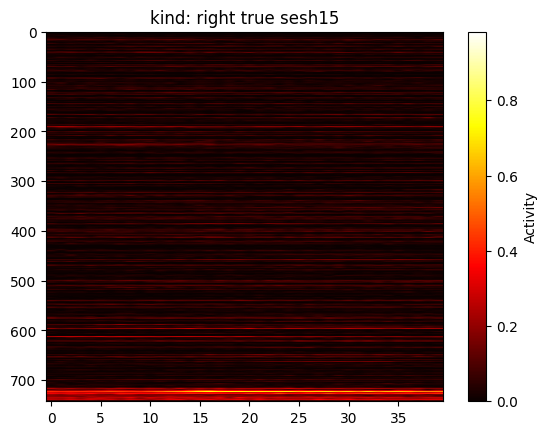

sesh15


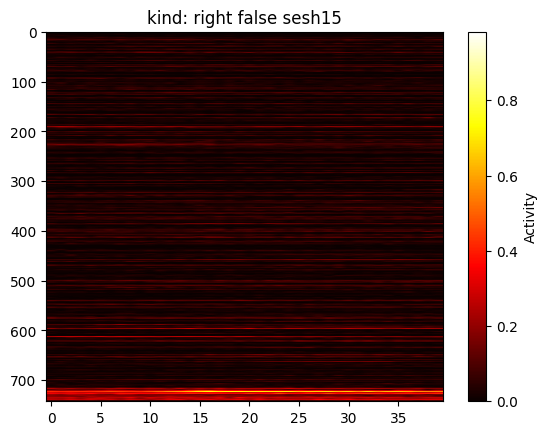

sesh15


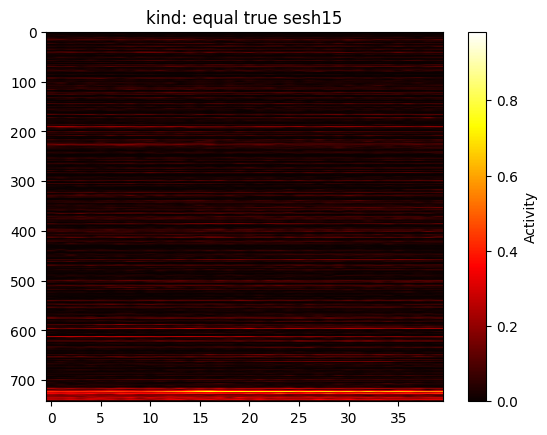

sesh16


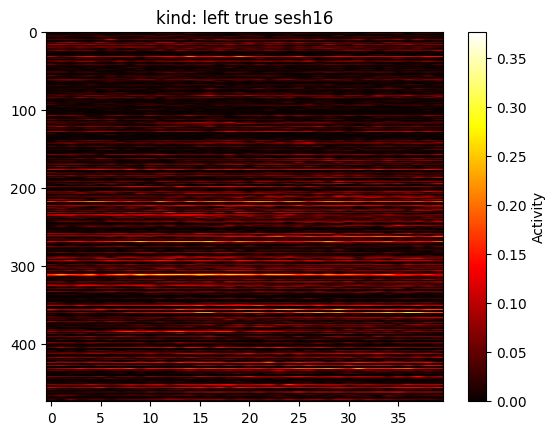

sesh16


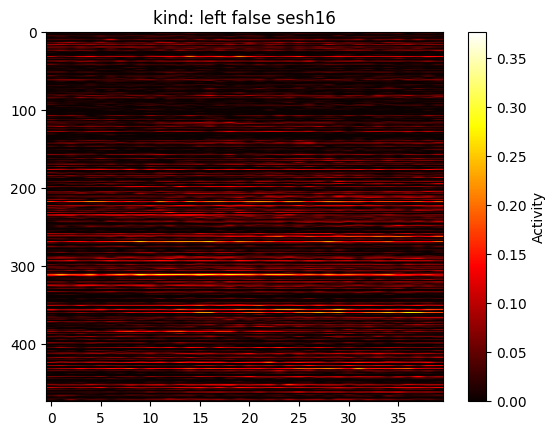

sesh16


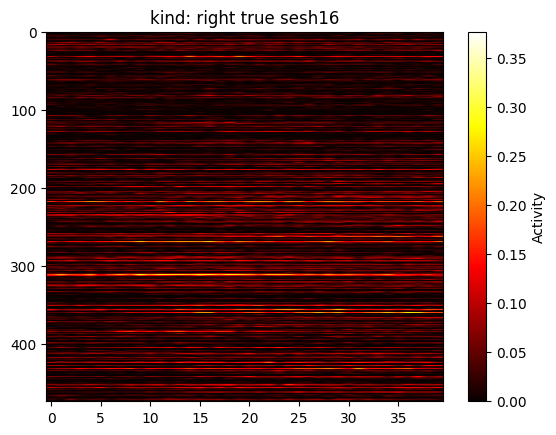

sesh16


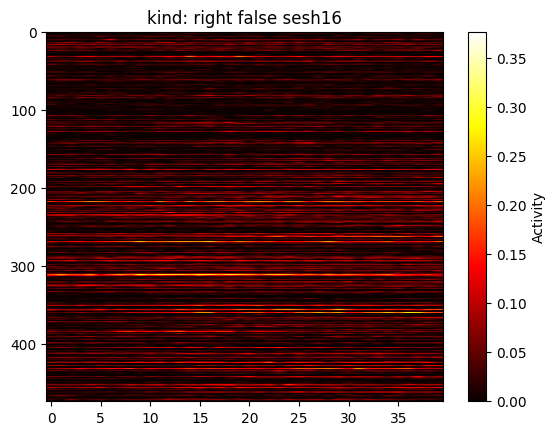

sesh16


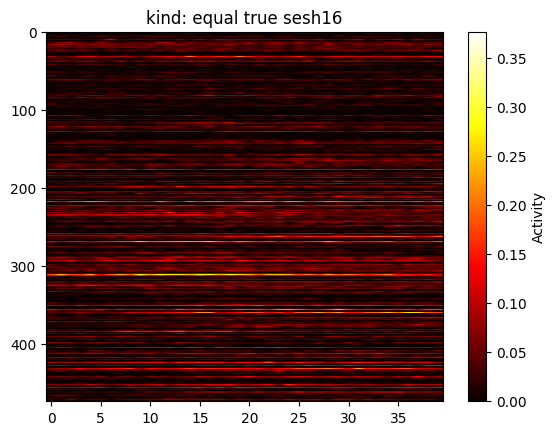

sesh17


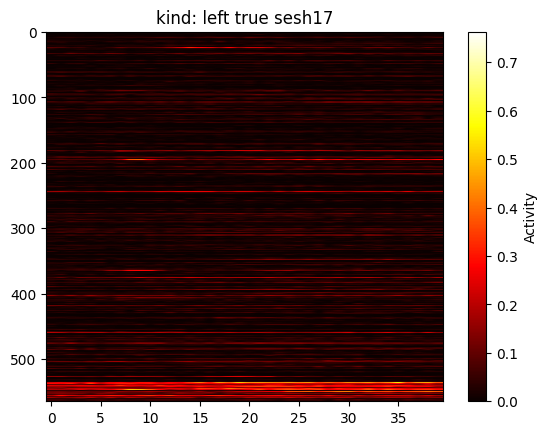

sesh17


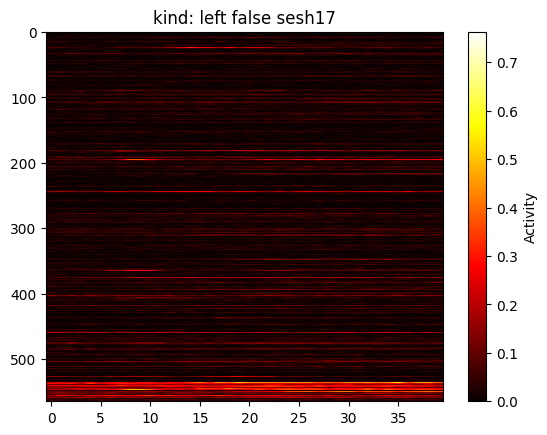

sesh17


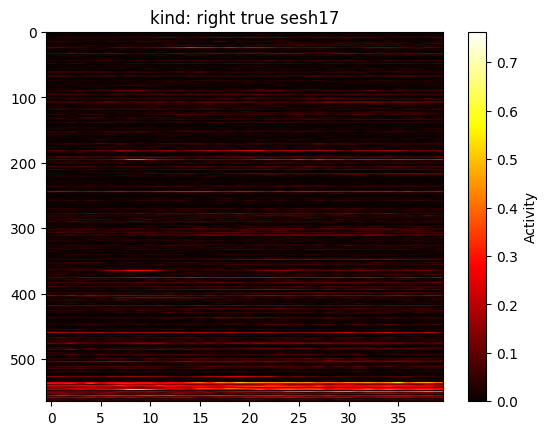

sesh17


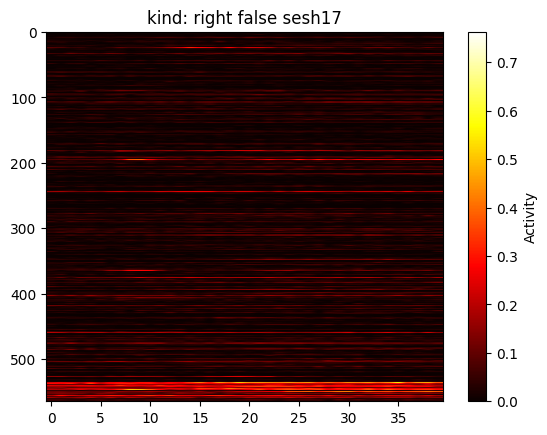

sesh17


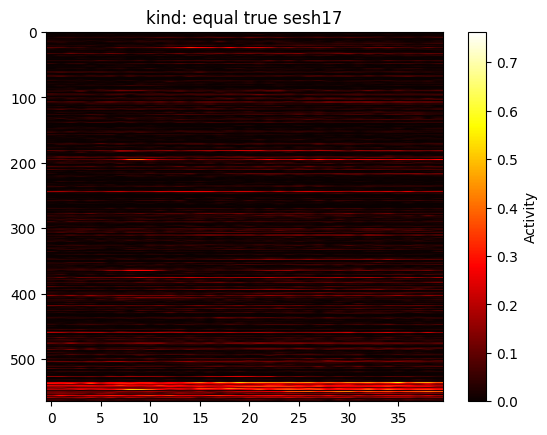

sesh18


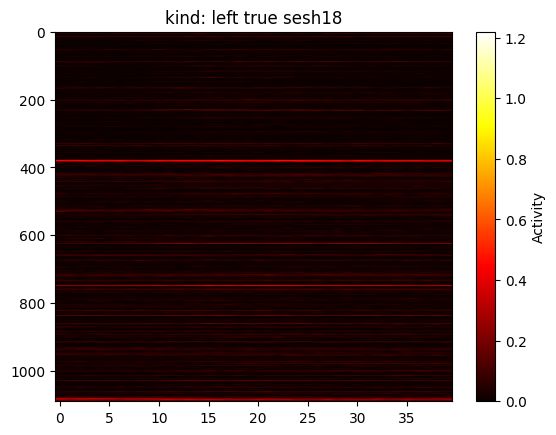

sesh18


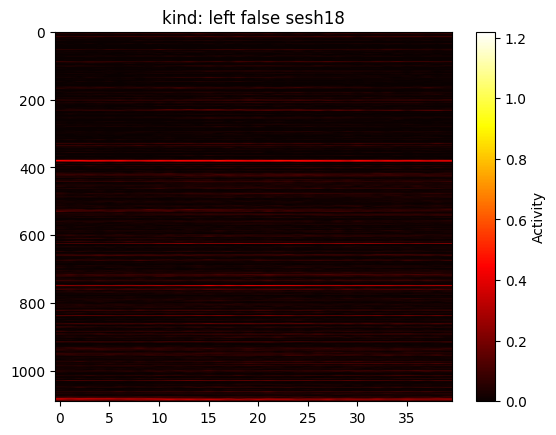

sesh18


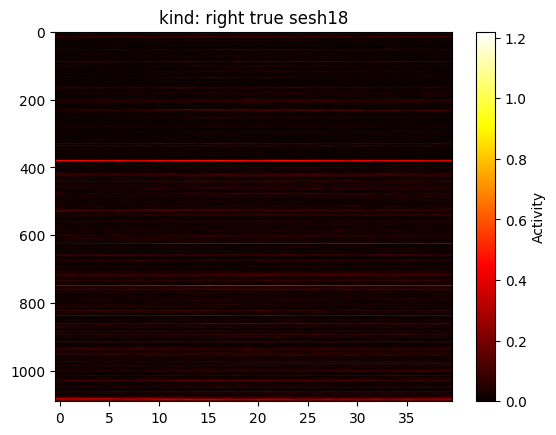

sesh18


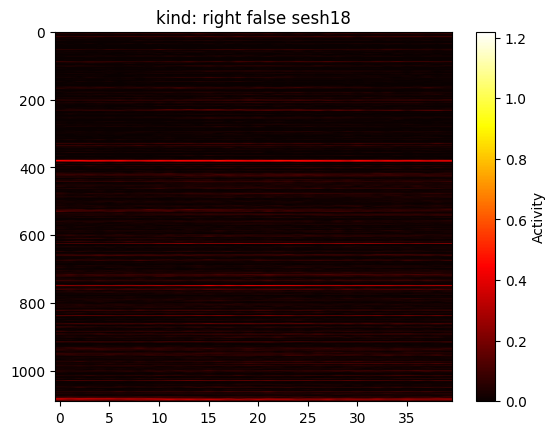

sesh18


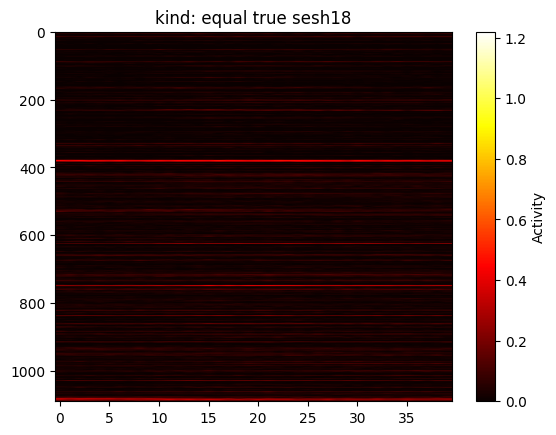

In [ ]:
# There are going to be a lot of matrices, so I will plot the average for each type across each session


for session in sessions:
  kinds = ["left true", "left false", "right true", "right false", "equal true"]
  kinds_data = [[] for i in range(len(kinds))]

  for i in range(len(kinds)):
    #print(kinds[i])
    #print(session.get_trial_kinds(kinds[i]))
    kinds_data[i].extend(session.get_trial_kinds(kinds[i]))


  counter = 0
  for kind in kinds_data:
    #print(len(kind))
    if len(kind) < 2:
      continue # we can't stack less than 2 matrices
    stacked_matrices = np.stack([trial.data for trial in kind])
    mean_across_matrices = np.mean(stacked_matrices, axis=0)
    print(session.name)
    plt.imshow(mean_across_matrices, aspect='auto', cmap='hot')
    plt.colorbar(label='Activity')
    string = "kind: " + kinds[counter] + " " + session.name
    counter += 1
    plt.title(string)
    plt.show()




Some observations:
- The graphs of average neurons differ greatly between sessions, and comparing them between sessions may not be reliable to begin with because of different neurons from different brain areas being selected, which we saw earlier

- Unfortuantely there are no stark noticable differences between left true and right true within sessions

- The graph also suggests the presence of "noisy" neurons which are always activated and may not porvide much useful information


In [20]:
# to see if the brian areas are consistant across sessions
all_brian_areas = []
for session in sessions:
  brian_areas = list(session.brain_area)
  all_brian_areas.extend(brian_areas)

unique_brian_areas = set(all_brian_areas)
unique_brian_areas = list(unique_brian_areas)
print(len(unique_brian_areas))
print(unique_brian_areas[:10], "\n", print(unique_brian_areas[10:20]), "\n", print(unique_brian_areas[20:30]), "\n", print(unique_brian_areas[30:40]), "\n", print(unique_brian_areas[40:50]), "\n", print(unique_brian_areas[50:60]))



62
['LS', 'POL', 'CA1', 'SCs', 'SSp', 'EPd', 'AUD', 'LSc', 'MEA', 'ACB']
['VISa', 'VPL', 'SSs', 'MG', 'VISam', 'DG', 'LD', 'MS', 'ZI', 'RN']
['PL', 'MB', 'LH', 'BLA', 'VISpm', 'ACA', 'VISrl', 'RSP', 'TT', 'OT']
['CA3', 'root', 'VPM', 'NB', 'LGd', 'TH', 'MOs', 'POST', 'VISp', 'MRN']
['SCsg', 'LSr', 'ILA', 'PT', 'MD', 'PAG', 'SI', 'PO', 'RT', 'PIR']
['SPF', 'CP', 'MOp', 'SUB', 'VISl', 'ORBm', 'GPe', 'SCm', 'SNr', 'LP'] 
 None 
 None 
 None 
 None 
 None


Starting with the first 10:

**TT: Taenia tecta**:

 https://www.sciencedirect.com/topics/medicine-and-dentistry/tenia-tecta
My analysis reveals it mostly attributed to odor processing. Thus it may not be relevant in processing visual information. Knowing about neural plasticity, in certain cases it may be relevant to visual processing. But as of now, it seems unlikely to be directly involved

**OLF olfacory**

https://www.physio-pedia.com/Olfactory_Cortex#:~:text=Olfactory%20Cortex%3A,to%20our%20memories%20and%20emotions.

Mainly used in processing odors as well, however, also used in memory formation and emotional response. It seems reasonable that this brain area may play a roll in learing

**GPe globus pallidus externa**
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7960779/

Mainly used in controlling involentary motor activity, which notably, includes rapid eyemovements. Thus is seems reasonable to include this brain group as possibly important

**VPL: ventral posterolateral nucleus**
https://link.springer.com/referenceworkentry/10.1007/978-3-540-29805-2_4751#:~:text=The%20VPL%20nucleus%20is%20a,posterior%20medial%20(VPM)%20nucleus.

Mainly used in processing somatosensory information, such as heat and pain. Unlikely to be relevant

**SSp: Primary somatosensory cortex**
https://neuroscientificallychallenged.com/posts/know-your-brain-primary-somatosensory-cortex#:~:text=The%20primary%20somatosensory%20cortex%20is%20responsible%20for%20processing%20somatic%20sensations,i.e.%20pain)%2C%20and%20temperature.

Also used in processing somatosensory information, specifically touch

**ZI: Zona incerta**
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7439563/#:~:text=The%20zona%20incerta%20(ZI)%20is,2%5D%E2%80%93%5B9%5D.

Arousal, shifts in attention, processing sensory information. Because of its role in sensory information processing, it seems inappropriate to rule out

**VISam: anteromedial area of Visual Cortex**

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7485906/#:~:text=The%20VISam%20and%20VISa%20areas,Itokazu%20et%20al.

involved in visual processing

**Aud: Auditory cortex**

https://www.sciencedirect.com/topics/medicine-and-dentistry/auditory-cortex#:~:text=Cortical%20processing%20in%20relation%20to,deficits%20in%20these%20basic%20functions

involved in hearing

**Aud: Auditory cortex**

https://www.sciencedirect.com/topics/medicine-and-dentistry/auditory-cortex#:~:text=Cortical%20processing%20in%20relation%20to,deficits%20in%20these%20basic%20functions

**ACA: anterior cerebral artery**
https://www.physio-pedia.com/Anterior_Cerebral_Artery

supplies blood to various parts of the brain including the sensory cortex. I am hesitant to rule it out because increased blood flow could correlate with the mouses perception of the image. I do not know enough about neurobiology to justify leaving this out.

**RN: red nucleus**
https://www.sciencedirect.com/topics/neuroscience/red-nucleus#:~:text=Structure%20and%20Function&text=Experimental%20data%20suggest%20that%20the,%2C%20see%20Holstege%2C%201991).

Not fully understood, but research suggests it is involved in blinking and in part in visual processing. Because of this I will leave it in


Now that I have investigated these, I will do t-tests to see if they have a significant difference across different contrast situations

In [21]:
print(type('TT'))

<class 'str'>


In [22]:
unique_brian_areas[:10]

['SPF', 'CP', 'MOp', 'SUB', 'VISl', 'ORBm', 'GPe', 'SCm', 'SNr', 'LP']

In [23]:
class Brain_area():
  def __init__(self, name):
    self.name = name
    self.first_t_statLR = None #left t test compared against right
    self.second_t_statLR = None

    self.first_t_statER = None #equal t test compared against right
    self.second_t_statER = None

    self.first_t_statEL = None #equal t test against left
    self.second_t_statEL = None

  def set_firstLR(self, first):
    self.first_t_statLR = first
  def set_secondLR(self, second):
    self.second_t_statLR = second

  def set_firstER(self, first):
    self.first_t_statER = first
  def set_secondER(self, second):
    self.second_t_statER = second

  def set_firstEL(self, first):
    self.first_t_statEL = first
  def set_secondEL(self, second):
    self.second_t_statEL = second

brain_area_objects = {}
for brian_area in unique_brian_areas:
  brain_area_objects[brian_area] = Brain_area(brian_area)



In [24]:
brain_area_objects

{'SPF': <__main__.Brain_area at 0x789f0273dd20>,
 'CP': <__main__.Brain_area at 0x789f0273efe0>,
 'MOp': <__main__.Brain_area at 0x789f0273efb0>,
 'SUB': <__main__.Brain_area at 0x789f0273ef50>,
 'VISl': <__main__.Brain_area at 0x789f0273ebf0>,
 'ORBm': <__main__.Brain_area at 0x789f0273fe80>,
 'GPe': <__main__.Brain_area at 0x789f0273fd90>,
 'SCm': <__main__.Brain_area at 0x789f0273d480>,
 'SNr': <__main__.Brain_area at 0x789f0273d030>,
 'LP': <__main__.Brain_area at 0x789f0273cd00>,
 'LS': <__main__.Brain_area at 0x789f0273fbb0>,
 'POL': <__main__.Brain_area at 0x789f0273f670>,
 'CA1': <__main__.Brain_area at 0x789f0273d360>,
 'SCs': <__main__.Brain_area at 0x789f0273ef20>,
 'SSp': <__main__.Brain_area at 0x789f0273d120>,
 'EPd': <__main__.Brain_area at 0x789f0273e860>,
 'AUD': <__main__.Brain_area at 0x789f0273f9a0>,
 'LSc': <__main__.Brain_area at 0x789f0273ee00>,
 'MEA': <__main__.Brain_area at 0x789f0273ee90>,
 'ACB': <__main__.Brain_area at 0x789f0273fd00>,
 'VISa': <__main__.Br

In [26]:
def get_brain_areas(parameter_brain_area):
  # to get all neurons with that brain area
  given_brain_area = []
  for session in sessions:
    for trial in session.trials:
      for neuron in trial.neurons:
        if neuron.brain_area == parameter_brain_area:
          given_brain_area.append(neuron)
  return given_brain_area




from scipy.stats import ttest_ind

def get_ttest(brain_area_name, brain_area_data, description):
  print('\n\n-------------\nDATA FOR BRAIN AREA:', brain_area_name) #so I know which results I'm looking at
  print('DESCRIPTION OF FUNCTION:   ', description)
  kinds_of_interest= ['left true', 'right true', 'equal true']
  left_first_half = [] # the average across the first .2 seconds
  right_first_half = []
  equal_first_half = []

  left_second_half = [] # the average across the second .2 seconds
  right_second_half = []
  equal_second_half = []

  for neuron in brain_area_data:
    if neuron.kind == kinds_of_interest[0]:
      left_first_half.append(np.mean(neuron.data[:20]))
      left_second_half.append(np.mean(neuron.data[20:]))

    if neuron.kind == kinds_of_interest[1]:
      right_first_half.append(np.mean(neuron.data[:20]))
      right_second_half.append(np.mean(neuron.data[20:]))
      #I will do a ttest for the first half and the second half of the time interval incase the nueron has the same average firing rate, but fires at different times

    if neuron.kind == kinds_of_interest[2]:
      equal_first_half.append(np.mean(neuron.data[:20]))
      equal_second_half.append(np.mean(neuron.data[20:]))


  t_statistic_first_halfLR, p_value_first_halfLR = ttest_ind(right_first_half, left_first_half, equal_var=False) # I set equal_var to false because our sample sizes are different

  print("~~~~~~~~~~~~~~~~~~SHOWING RIGHT LEFT ~~~~~~~~~~~~~~~~~~~\n\n")
  print('\nmean left_first_halfLR ', np.mean(left_first_half), 'len left_first_half', len(left_first_half), '\n')
  print('mean right_equal_first_half', np.mean(right_first_half), 'len right_first_half', len(right_first_half), '\n')
  print("T-statistic_first_half:", abs(t_statistic_first_halfLR))

  brain_area_objects[brain_area_name].set_firstLR(abs(t_statistic_first_halfLR))

  t_statistic_second_halfLR, p_value_second_halfLR = ttest_ind(right_second_half, left_second_half, equal_var=False)

  print('\nmean left_second_half ', np.mean(left_second_half), 'len left_second_half', len(left_second_half), '\n')
  print('mean right_second_half', np.mean(right_second_half), 'len right_second_half', len(right_second_half), '\n')
  print("T-statistic_second_half:", abs(t_statistic_second_halfLR))

  brain_area_objects[brain_area_name].set_secondLR(abs(t_statistic_second_halfLR))

  t_statistic_first_halfER, p_value_first_halfER = ttest_ind(right_first_half, equal_first_half, equal_var=False)
  print("~~~~~~~~~~~~~~~~~~SHOWING RIGHT EQUAL ~~~~~~~~~~~~~~~~~~~\n\n")
  print('\nmean equal_first_half ', np.mean(equal_first_half), 'len equal_first_half', len(equal_first_half), '\n')
  print('mean right_equal_first_half', np.mean(right_first_half), 'len right_first_half', len(right_first_half), '\n')
  print("T-statistic_first_half:", abs(t_statistic_first_halfER))

  brain_area_objects[brain_area_name].set_firstER(abs(t_statistic_first_halfER))

  t_statistic_second_halfER, p_value_second_halfER = ttest_ind(right_second_half, equal_second_half, equal_var=False)

  print('\nmean equal_second_half ', np.mean(equal_second_half), 'len equal_second_half', len(equal_second_half), '\n')
  print('mean right_second_half', np.mean(right_second_half), 'len right_second_half', len(right_second_half), '\n')
  print("T-statistic_second_halfER:", abs(t_statistic_second_halfER))

  brain_area_objects[brain_area_name].set_secondER(abs(t_statistic_second_halfER))

  t_statistic_first_halfEL, p_value_first_halfEL = ttest_ind(left_first_half, equal_first_half, equal_var=False)
  print("~~~~~~~~~~~~~~~~~~SHOWING EQUAL LEFT ~~~~~~~~~~~~~~~~~~~\n\n")
  print('\nmean equal_first_half ', np.mean(equal_first_half), 'len equal_first_half', len(equal_first_half), '\n')
  print('mean left_equal_first_half', np.mean(left_first_half), 'len left_first_half', len(left_first_half), '\n')
  print("T-statistic_first_half:", abs(t_statistic_first_halfEL))

  brain_area_objects[brain_area_name].set_firstEL(abs(t_statistic_first_halfEL))

  t_statistic_second_halfEL, p_value_second_halfEL = ttest_ind(left_second_half, equal_second_half, equal_var=False)

  print('\nmean equal_second_half ', np.mean(equal_second_half), 'len equal_second_half', len(equal_second_half), '\n')
  print('mean left_second_half', np.mean(left_second_half), 'len left_second_half', len(left_second_half), '\n')
  print("T-statistic_second_halfEL:", abs(t_statistic_second_halfEL))

  brain_area_objects[brain_area_name].set_secondEL(abs(t_statistic_second_halfEL))

descriptions = ['odor', 'odor', 'unconsious motor activity including eye movement', 'somatosensory information', 'somatosensory information', 'Arousal, shifts in attention, processing sensory information', 'involved in visual processing', 'involved in hearing', 'supplies blood to various parts of the brain including the sensory cortex', 'Not fully understood, but research suggests it is involved in blinking and in part in visual processing.']
counter = 0
sig_brain_areas = []
for brain_area in ['TT', 'OLF', 'GPe', 'VPL', 'SSp', 'ZI', 'VISam', 'AUD', 'ACA', 'RN']:
  matching_neurons = get_brain_areas(brain_area)
  get_ttest(brain_area, matching_neurons, descriptions[counter])
  counter+=1









-------------
DATA FOR BRAIN AREA: TT
DESCRIPTION OF FUNCTION:    odor
~~~~~~~~~~~~~~~~~~SHOWING RIGHT LEFT ~~~~~~~~~~~~~~~~~~~



mean left_first_halfLR  0.02600533807829181 len left_first_half 5620 

mean right_equal_first_half 0.031636757425742575 len right_first_half 3232 

T-statistic_first_half: 3.6335375924585187

mean left_second_half  0.031752669039145906 len left_second_half 5620 

mean right_second_half 0.04243502475247525 len right_second_half 3232 

T-statistic_second_half: 4.811123925905071
~~~~~~~~~~~~~~~~~~SHOWING RIGHT EQUAL ~~~~~~~~~~~~~~~~~~~



mean equal_first_half  0.024549774887443723 len equal_first_half 3998 

mean right_equal_first_half 0.031636757425742575 len right_first_half 3232 

T-statistic_first_half: 4.371455447585102

mean equal_second_half  0.02541270635317659 len equal_second_half 3998 

mean right_second_half 0.04243502475247525 len right_second_half 3232 

T-statistic_second_halfER: 7.70142973201173
~~~~~~~~~~~~~~~~~~SHOWING EQUAL LEFT ~~~~~~~~~

Our statistically significant brain areas from this subset are TT, GPe, and VISam which are responsible for odor processing, involentary motor activity, which notably, includes rapid eyemovements, and visual processing. These results mostly coincide with our intuition

**Next round of investigation**

'VISpm', 'RT', 'PO', 'PL', 'LD', 'DG', 'ILA', 'NB', 'VISrl', 'MG'
- This time I am just going to use chatgpt to get a breif idea of what each does, and then I will research furthure if nessecary

**VISpm: Visual posterior medial area**

A region in the posterior part of the visual cortex, involved in visual processing.

**RT: The reticular nucleus of the thalamus**

This structure is part of the thalamus and plays a role in regulating information flow through the thalamus.

**PO: Posterior complex of the thalamus**

 Involved in relaying sensory information to the cerebral cortex.

**PL: Prelimbic cortex**

A part of the prefrontal cortex involved in executive functions and decision-making.

**Lateral dorsal nucleus of the thalamus**

 Plays a role in relaying sensory and motor information.

**DG: Dentate gyrus**

A region within the hippocampus involved in memory formation and spatial cognition.

**ILA: Infralimbic cortex**

Another part of the prefrontal cortex involved in decision-making and response inhibition.

**NB: Nucleus basalis.**

A group of neurons in the basal forebrain that releases acetylcholine and is involved in attention and learning.

**VISrl: Visual posterior lateral area.**

 Another region in the visual cortex, likely involved in processing visual information.

**MG: Medial geniculate nucleus.**

Found in the thalamus, involved in processing auditory information and relaying it to the auditory cortex.



In [27]:
descriptions = ['vision', 'information flow', 'sensory info', 'decision making', 'sensory and motor information', 'memory formation', 'decision_making', 'attention and learning', 'vision', 'hearing']
counter = 0
for brain_area in ['VISpm', 'RT', 'PO', 'PL', 'LD', 'DG', 'ILA', 'NB', 'VISrl', 'MG']:
  matching_neurons = get_brain_areas(brain_area)
  get_ttest(brain_area, matching_neurons, descriptions[counter])
  counter+=1





-------------
DATA FOR BRAIN AREA: VISpm
DESCRIPTION OF FUNCTION:    vision
~~~~~~~~~~~~~~~~~~SHOWING RIGHT LEFT ~~~~~~~~~~~~~~~~~~~



mean left_first_halfLR  0.037523651844843894 len left_first_half 8456 

mean right_equal_first_half 0.03836423841059603 len right_first_half 7550 

T-statistic_first_half: 0.6771455159506802

mean left_second_half  0.039545884578997166 len left_second_half 8456 

mean right_second_half 0.04014569536423841 len right_second_half 7550 

T-statistic_second_half: 0.5012481935294647
~~~~~~~~~~~~~~~~~~SHOWING RIGHT EQUAL ~~~~~~~~~~~~~~~~~~~



mean equal_first_half  0.03382312362030905 len equal_first_half 14496 

mean right_equal_first_half 0.03836423841059603 len right_first_half 7550 

T-statistic_first_half: 4.230642284385144

mean equal_second_half  0.03395764348785872 len equal_second_half 14496 

mean right_second_half 0.04014569536423841 len right_second_half 7550 

T-statistic_second_halfER: 6.006010609070279
~~~~~~~~~~~~~~~~~~SHOWING EQUAL LEFT ~~

Next round of analysis:

['MEA', 'LP', 'LS', 'VISa', 'root', 'TH', 'SCm', 'SPF', 'ORB', 'SUB']

**MEA (Medial Amygdala)**:

 Involved in the processing and regulation of emotions, particularly social and reproductive behaviors.

**LP (Lateral Posterior nucleus of the thalamus)**:

 Plays a role in relaying sensory information, particularly somatosensory and visual information, to the cerebral cortex.

**LS (Lateral Septal Nucleus)**:

Regulates various behaviors, including aggression, social interactions, and stress responses.

**VISa (Anterior visual area)**:

 Part of the visual cortex involved in processing visual information, particularly in the anterior part of the brain.

**Root (Root nucleus of the thalamus)**:

 This term might refer to the thalamic reticular nucleus (TRN), which surrounds the thalamus and modulates information flow within the thalamus.

**TH (Thalamus)**:

Acts as a relay station for sensory and motor signals, relaying information to and from the cerebral cortex and other parts of the brain.

**SCm (Superior Colliculus, motor part)**:

Involved in the generation and control of eye movements, particularly saccadic eye movements.

**SPF (Subparafascicular nucleus)**:

A part of the thalamus involved in modulating arousal, attention, and nociception.

**ORB (Orbital cortex):**

 Plays a role in decision-making, emotional processing, and social behavior.

**SUB (Subiculum)**:

Acts as a major output region of the hippocampus and is involved in spatial navigation, memory consolidation, and context-dependent behavior.



In [28]:
descriptions = ['Emotion', 'Sensory', 'Social', 'Visual', 'Relay', 'Relay', 'Eye', 'Arousal', 'Decision', 'Memory']
counter = 0
for brain_area in ['MEA', 'LP', 'LS', 'VISa', 'root', 'TH', 'SCm', 'SPF', 'ORB', 'SUB']:
  matching_neurons = get_brain_areas(brain_area)
  get_ttest(brain_area, matching_neurons, descriptions[counter])
  counter+=1






-------------
DATA FOR BRAIN AREA: MEA
DESCRIPTION OF FUNCTION:    Emotion
~~~~~~~~~~~~~~~~~~SHOWING RIGHT LEFT ~~~~~~~~~~~~~~~~~~~



mean left_first_halfLR  0.024057649667405763 len left_first_half 1353 

mean right_equal_first_half 0.023652118100128367 len right_first_half 1558 

T-statistic_first_half: 0.17354455554303064

mean left_second_half  0.021618625277161862 len left_second_half 1353 

mean right_second_half 0.028915275994865215 len right_second_half 1558 

T-statistic_second_half: 3.2597237710383067
~~~~~~~~~~~~~~~~~~SHOWING RIGHT EQUAL ~~~~~~~~~~~~~~~~~~~



mean equal_first_half  0.021226104152933422 len equal_first_half 1517 

mean right_equal_first_half 0.023652118100128367 len right_first_half 1558 

T-statistic_first_half: 1.1459339037201703

mean equal_second_half  0.022050098879367173 len equal_second_half 1517 

mean right_second_half 0.028915275994865215 len right_second_half 1558 

T-statistic_second_halfER: 3.098424584559119
~~~~~~~~~~~~~~~~~~SHOWING EQUAL LE

In [29]:
counter = 0
descriptions = ['Visual', 'Sensory', 'Visual', 'Regulation', 'Sensory', 'Olfactory', 'Sensory', 'Motor', 'Hypothalamus', 'Sensory']
for brain_area in ['SCsg', 'LGd', 'VISl', 'MRN', 'SSs', 'PIR', 'SCs', 'MB', 'LH', 'PT']:
  matching_neurons = get_brain_areas(brain_area)
  get_ttest(brain_area, matching_neurons, descriptions[counter])
  counter+=1






-------------
DATA FOR BRAIN AREA: SCsg
DESCRIPTION OF FUNCTION:    Visual
~~~~~~~~~~~~~~~~~~SHOWING RIGHT LEFT ~~~~~~~~~~~~~~~~~~~



mean left_first_halfLR  0.03366606170598911 len left_first_half 551 

mean right_equal_first_half 0.04718045112781955 len right_first_half 266 

T-statistic_first_half: 1.4757530325784736

mean left_second_half  0.03720508166969147 len left_second_half 551 

mean right_second_half 0.030263157894736846 len right_second_half 266 

T-statistic_second_half: 0.8982474391372701
~~~~~~~~~~~~~~~~~~SHOWING RIGHT EQUAL ~~~~~~~~~~~~~~~~~~~



mean equal_first_half  0.032252141982864135 len equal_first_half 817 

mean right_equal_first_half 0.04718045112781955 len right_first_half 266 

T-statistic_first_half: 1.6895377680566581

mean equal_second_half  0.033720930232558136 len equal_second_half 817 

mean right_second_half 0.030263157894736846 len right_second_half 266 

T-statistic_second_halfER: 0.46060730060354393
~~~~~~~~~~~~~~~~~~SHOWING EQUAL LEFT ~~~~~~~~

In [30]:
['VPM', 'POST', 'ORBm', 'LSr', 'VISp', 'POL', 'CP', 'PAG', 'BLA', 'MOp', 'MS', 'MOs', 'RSP', 'LSc', 'CA1', 'EPd', 'MD', 'CA3']

['VPM',
 'POST',
 'ORBm',
 'LSr',
 'VISp',
 'POL',
 'CP',
 'PAG',
 'BLA',
 'MOp',
 'MS',
 'MOs',
 'RSP',
 'LSc',
 'CA1',
 'EPd',
 'MD',
 'CA3']

In [31]:
counter = 0
descriptions = ['Sensory', 'Sensory', 'Decision', 'Social', 'Visual', 'Olfactory', 'Cognitive', 'Regulation', 'Emotion', 'Motor', 'Sensory', 'Motor', 'Cognitive', 'Motor', 'Memory', 'Emotion', 'Sensory', 'Memory']
for brain_area in ['VPM', 'POST', 'ORBm', 'LSr', 'VISp', 'POL', 'CP', 'PAG', 'BLA', 'MOp', 'MS', 'MOs', 'RSP', 'LSc', 'CA1', 'EPd', 'MD', 'CA3']:
  matching_neurons = get_brain_areas(brain_area)
  get_ttest(brain_area, matching_neurons, descriptions[counter])
  counter+=1





-------------
DATA FOR BRAIN AREA: VPM
DESCRIPTION OF FUNCTION:    Sensory
~~~~~~~~~~~~~~~~~~SHOWING RIGHT LEFT ~~~~~~~~~~~~~~~~~~~



mean left_first_halfLR  0.03551014957264957 len left_first_half 7488 

mean right_equal_first_half 0.038316286388670344 len right_first_half 7626 

T-statistic_first_half: 1.7257560121819553

mean left_second_half  0.039496527777777776 len left_second_half 7488 

mean right_second_half 0.0444662995017047 len right_second_half 7626 

T-statistic_second_half: 2.710494694881078
~~~~~~~~~~~~~~~~~~SHOWING RIGHT EQUAL ~~~~~~~~~~~~~~~~~~~



mean equal_first_half  0.03410080557369911 len equal_first_half 9186 

mean right_equal_first_half 0.038316286388670344 len right_first_half 7626 

T-statistic_first_half: 2.727540677806972

mean equal_second_half  0.034470934030045725 len equal_second_half 9186 

mean right_second_half 0.0444662995017047 len right_second_half 7626 

T-statistic_second_halfER: 5.912572926393225
~~~~~~~~~~~~~~~~~~SHOWING EQUAL LEFT ~~~~~~

In [33]:
for key in brain_area_objects:
  if brain_area_objects[key].first_t_statLR is None:
    print(key)
  if brain_area_objects[key].first_t_statER is None:
    print(key)
  if brain_area_objects[key].first_t_statEL is None:
    print(key)

# we have some nan and None values for when we had to divide by 0

SNr
SNr
SNr
ACB
ACB
ACB
OT
OT
OT
SI
SI
SI


In [35]:
# looks like I forgot about those
counter = 0
descriptions = ['Substantia Nigra pars reticulata', 'Nucleus Accumbens', 'Olfactory Tubercle', 'Substantia Innominata']
for brain_area in ['SNr', 'ACB', 'OT', 'SI']:
  matching_neurons = get_brain_areas(brain_area)
  get_ttest(brain_area, matching_neurons, descriptions[counter])
  counter+=1



-------------
DATA FOR BRAIN AREA: SNr
DESCRIPTION OF FUNCTION:    Substantia Nigra pars reticulata
~~~~~~~~~~~~~~~~~~SHOWING RIGHT LEFT ~~~~~~~~~~~~~~~~~~~



mean left_first_halfLR  0.02801775147928994 len left_first_half 5070 

mean right_equal_first_half 0.02964835164835165 len right_first_half 4550 

T-statistic_first_half: 0.7200306634847075

mean left_second_half  0.03036489151873767 len left_second_half 5070 

mean right_second_half 0.03208791208791209 len right_second_half 4550 

T-statistic_second_half: 0.6650411960177877
~~~~~~~~~~~~~~~~~~SHOWING RIGHT EQUAL ~~~~~~~~~~~~~~~~~~~



mean equal_first_half  0.02711018711018711 len equal_first_half 4810 

mean right_equal_first_half 0.02964835164835165 len right_first_half 4550 

T-statistic_first_half: 1.1771551750753406

mean equal_second_half  0.026923076923076925 len equal_second_half 4810 

mean right_second_half 0.03208791208791209 len right_second_half 4550 

T-statistic_second_halfER: 2.1482393066191947
~~~~~~~~~~~~~~~~

In [36]:
for key in brain_area_objects:
  if brain_area_objects[key].first_t_statLR is None:
    print(key)
  if brain_area_objects[key].first_t_statER is None:
    print(key)
  if brain_area_objects[key].first_t_statEL is None:
    print(key)

We are going to remove all brain areas that are not significant at alpha = .01

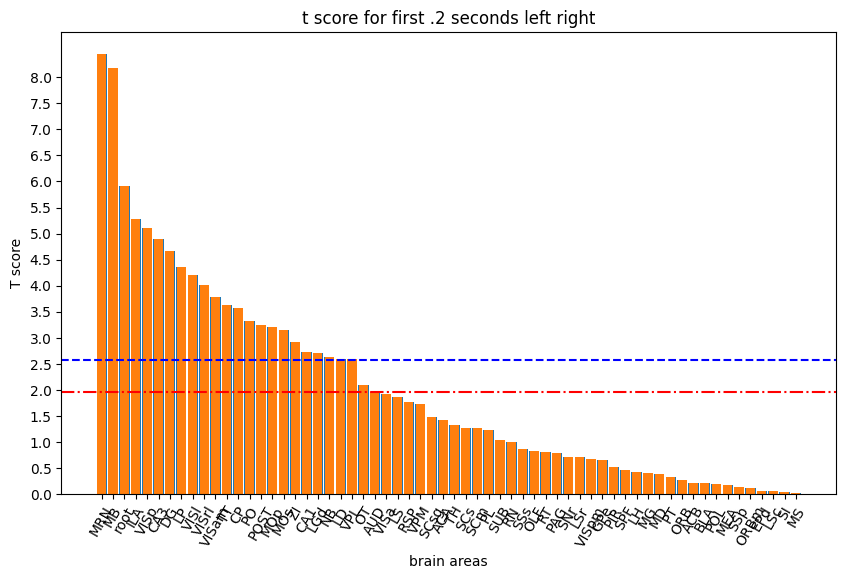

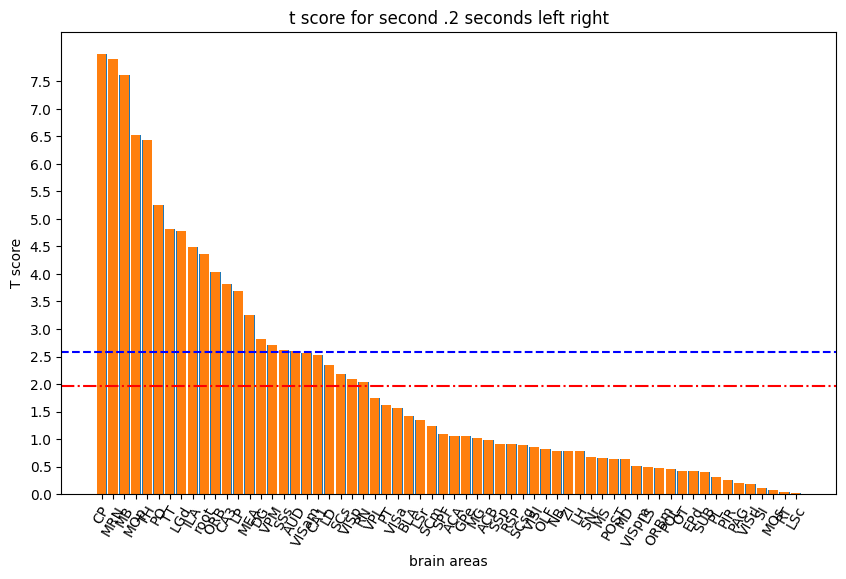

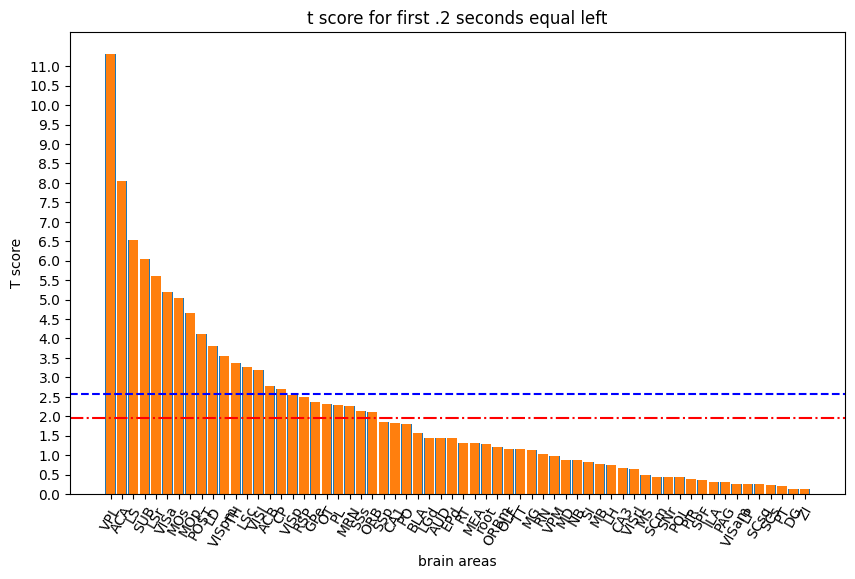

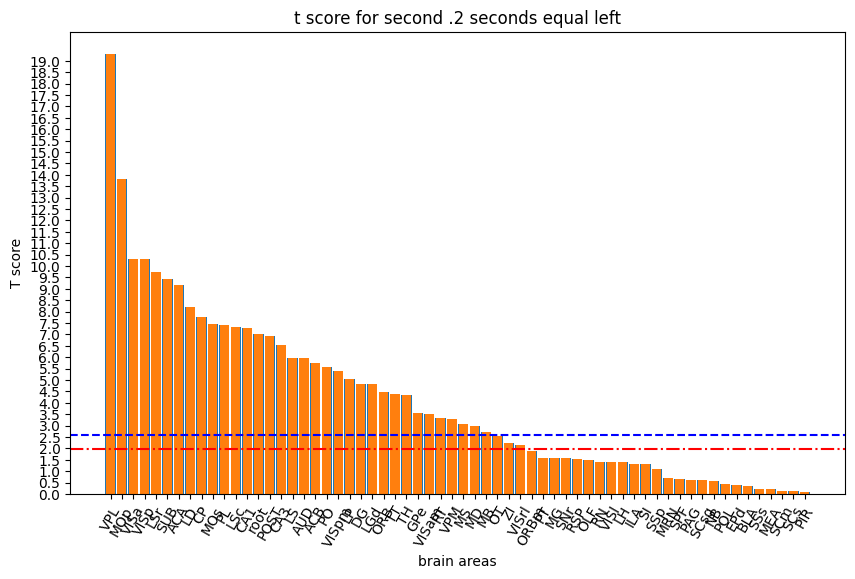

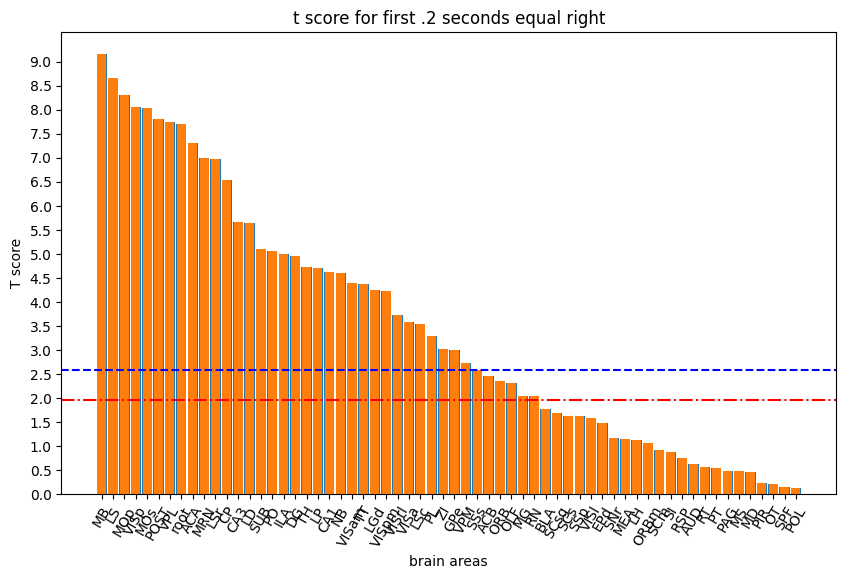

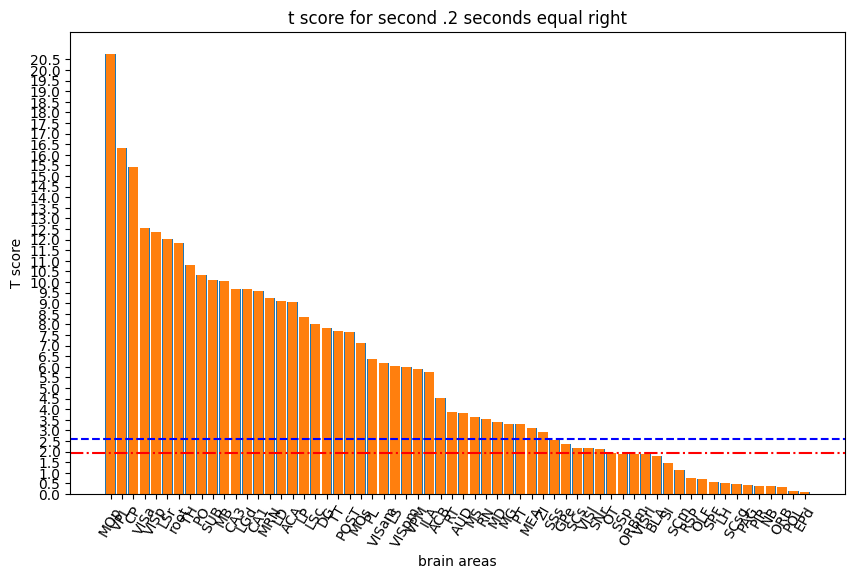

In [43]:
import math
namesfirstLR = []
firstLR = []
namessecondLR = []
secondLR = []

namesfirstEL = []
firstEL = []
namessecondEL = []
secondEL = []

namesfirstER = []
firstER = []
namessecondER = []
secondER = []

allnames = []

for key in brain_area_objects:
  allnames.append(key)
  if brain_area_objects[key].first_t_statLR is not None and not (math.isnan(brain_area_objects[key].first_t_statLR)):
    firstLR.append(brain_area_objects[key].first_t_statLR)
    namesfirstLR.append(key)

  if brain_area_objects[key].second_t_statLR is not None and not (math.isnan(brain_area_objects[key].second_t_statLR)):
    secondLR.append(brain_area_objects[key].second_t_statLR)
    namessecondLR.append(key)

  if brain_area_objects[key].first_t_statEL is not None and not (math.isnan(brain_area_objects[key].first_t_statEL)):
    firstEL.append(brain_area_objects[key].first_t_statEL)
    namesfirstEL.append(key)

  if brain_area_objects[key].second_t_statEL is not None and not (math.isnan(brain_area_objects[key].second_t_statEL)):
    secondEL.append(brain_area_objects[key].second_t_statEL)
    namessecondEL.append(key)

  if brain_area_objects[key].first_t_statER is not None and not (math.isnan(brain_area_objects[key].first_t_statER)):
    firstER.append(brain_area_objects[key].first_t_statER)
    namesfirstER.append(key)

  if brain_area_objects[key].second_t_statER is not None and not (math.isnan(brain_area_objects[key].second_t_statER)):
    secondER.append(brain_area_objects[key].second_t_statER)
    namessecondER.append(key)


def get_bar_graph(data, labels, title, cut):

    my_dict = {label: datum for label, datum in zip(labels, data)}
    sorted_dict = dict(sorted(my_dict.items(), key=lambda item: item[1], reverse=True))
    new_labels = []
    new_data = []
    for key in sorted_dict:
      new_labels.append(key)
      new_data.append(sorted_dict[key])
    plt.figure(figsize=(10, 6))
    plt.bar(new_labels, new_data, width=.9)
    plt.bar(new_labels, new_data)
    plt.xticks(rotation=60, ha='center')
    plt.xlabel('brain areas')
    plt.ylabel('T score')
    plt.title(title)
    plt.yticks([i/2 for i in range(int(max(new_data)*2) + 1)])
    plt.axhline(y=1.96, color='red', linestyle='-.') # show significant line
    plt.axhline(y=cut, color='blue', linestyle='--')
    plt.show()
    # getting the t scores above the cut off
    sig = []
    for datum in range(len(data)):
      if data[datum] > cut:
        sig.append(labels[datum])
    return sig




sig_firstLR = get_bar_graph(firstLR, namesfirstLR, 't score for first .2 seconds left right', 2.58 ) # where I notice a cut off



sig_secondLR = get_bar_graph(secondLR, namessecondLR, 't score for second .2 seconds left right', 2.58 )


sig_firstEL = get_bar_graph(firstEL, namesfirstEL, 't score for first .2 seconds equal left', 2.58 ) # where I notice a cut off


sig_secondEL = get_bar_graph(secondEL, namessecondEL, 't score for second .2 seconds equal left', 2.58 )

sig_firstER = get_bar_graph(firstER, namesfirstER, 't score for first .2 seconds equal right', 2.58 ) # where I notice a cut off


sig_secondER = get_bar_graph(secondER, namessecondER, 't score for second .2 seconds equal right', 2.58 )


In [44]:
#significant brain areas for each half of the time interval

print(sig_firstEL)
print(sig_secondEL)

print(sig_firstER)
print(sig_secondER)

print(sig_firstLR)
print(sig_secondLR)

['CP', 'MOp', 'SUB', 'VISl', 'LS', 'LSc', 'ACB', 'VISa', 'VPL', 'LD', 'VISpm', 'ACA', 'TH', 'MOs', 'POST', 'LSr']
['CP', 'MOp', 'SUB', 'GPe', 'LP', 'LS', 'CA1', 'AUD', 'LSc', 'ACB', 'VISa', 'VPL', 'VISam', 'DG', 'LD', 'MS', 'PL', 'MB', 'VISpm', 'ACA', 'TT', 'CA3', 'root', 'VPM', 'LGd', 'TH', 'MOs', 'POST', 'VISp', 'LSr', 'MD', 'PO', 'RT', 'ORB']
['CP', 'MOp', 'SUB', 'GPe', 'LP', 'LS', 'CA1', 'LSc', 'VISa', 'VPL', 'SSs', 'VISam', 'DG', 'LD', 'ZI', 'PL', 'MB', 'VISpm', 'ACA', 'VISrl', 'TT', 'CA3', 'root', 'VPM', 'NB', 'LGd', 'TH', 'MOs', 'POST', 'VISp', 'MRN', 'LSr', 'ILA', 'PO']
['CP', 'MOp', 'SUB', 'LP', 'LS', 'CA1', 'AUD', 'LSc', 'MEA', 'ACB', 'VISa', 'VPL', 'MG', 'VISam', 'DG', 'LD', 'MS', 'ZI', 'RN', 'PL', 'MB', 'VISpm', 'ACA', 'TT', 'CA3', 'root', 'VPM', 'LGd', 'TH', 'MOs', 'POST', 'VISp', 'MRN', 'LSr', 'ILA', 'PT', 'MD', 'PO', 'RT']
['CP', 'MOp', 'VISl', 'LP', 'CA1', 'VPL', 'VISam', 'DG', 'LD', 'ZI', 'MB', 'VISrl', 'TT', 'CA3', 'root', 'NB', 'LGd', 'MOs', 'POST', 'VISp', 'MRN', 'I

In [45]:
# we will take the union of these to reflect the fact that we want to consider brain areas that are significant in either part of the time interval

sig_firstEL = set(sig_firstEL)
sig_secondEL = set(sig_secondEL)
sig_firstER = set(sig_firstER)
sig_secondER = set(sig_secondER)
sig_firstLR = set(sig_firstLR)
sig_secondLR = set(sig_secondLR)


sig_union = list(sig_firstEL | sig_secondEL | sig_firstER | sig_secondER | sig_firstLR | sig_secondLR)

In [46]:
sig_union

['CP',
 'MOp',
 'SUB',
 'VISl',
 'GPe',
 'LP',
 'LS',
 'CA1',
 'ACB',
 'LSc',
 'AUD',
 'MEA',
 'VISa',
 'VPL',
 'SSs',
 'MG',
 'VISam',
 'DG',
 'MS',
 'LD',
 'ZI',
 'RN',
 'PL',
 'MB',
 'VISpm',
 'VISrl',
 'ACA',
 'TT',
 'CA3',
 'root',
 'VPM',
 'NB',
 'TH',
 'LGd',
 'MOs',
 'POST',
 'VISp',
 'MRN',
 'LSr',
 'ILA',
 'PT',
 'MD',
 'PO',
 'RT',
 'ORB']

In [47]:
difference = [x for x in allnames if x not in sig_union]
print(difference)
# these are all the ones we deleted
print(len(difference))

['SPF', 'ORBm', 'SCm', 'SNr', 'POL', 'SCs', 'SSp', 'EPd', 'LH', 'BLA', 'RSP', 'OT', 'SCsg', 'PAG', 'SI', 'PIR', 'OLF']
17


In [49]:
# we are going to delete the connectors for all neurons associated with brain areas not listed here

unsignificant = [x for x in allnames if x not in sig_union]




In [74]:
unsignificant

['SPF',
 'ORBm',
 'SCm',
 'SNr',
 'POL',
 'SCs',
 'SSp',
 'EPd',
 'LH',
 'BLA',
 'RSP',
 'OT',
 'SCsg',
 'PAG',
 'SI',
 'PIR',
 'OLF']

# NOTE TO SELF ^^ DO NOT RUN TWICE

Note: I accidently ran it twice anf thats why theres an error

We are gonna need a new class just called sig neurons to reflect the class that we don't need all the trial and session information anymore

In [90]:
# the goal is to end up with a list of neurons with all the data across trials for each section

class Grouped_neuron():
  # where as are neuron instant class represented neuron each neurons behavior in a specific trial as a seperate instance, this class groups neurons across trials
  def __init__(self, left_true, right_true, left_false, right_false, equal_true, source_session, brain_area, neurons):
    self.left_true = left_true
    self.avg_left = None
    self.right_true = right_true
    self.avg_right = None
    self.left_false = left_false
    self.neurons = neurons # this is important because later we will need a way to seperate these by trials
    # these are the neuron instances which contain info about the trials they came from
    self.right_false = right_false
    self.equal_true = equal_true
    self.avg_equal = None
    self.left_right_equal = None
    self.session_num = source_session
    if brain_area in unsignificant:
      raise ValueError(brain_area)
    else:
      self.brain_area = brain_area
    self.cluster = None
  def set_cluster(self, cluster):
    self.cluster = cluster
    for neuron in self.neurons:
      neuron.cluster = self.cluster

  def get_avgs(self):
    avg_left= [sum(values) / len(values) for values in zip(*self.left_true)] #will return one list of element wise averages
    if len(avg_left) != 40:
      raise ValueError("something unexpected occured! lenght avg left = " + str(len(avg_left)))

    avg_right= [sum(values) / len(values) for values in zip(*self.right_true)]
    if len(avg_right) != 40:
      raise ValueError("something unexpected occured! lenght avg_right = " + str(len(avg_right)))
    avg_equal = [sum(values) / len(values) for values in zip(*self.equal_true)]
    if len(avg_equal) != 40:
      raise ValueError("something unexpected occured! lenght avg_right = " + str(len(avg_equal)))
    self.left_right_equal = avg_left + avg_right + avg_equal # this is what we will use for clustering




[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [91]:


print(len(sessions))

#contrasts = ["left true", "right true", "equal true"]
unsig_counter = 0 # to see how many unsignificant brain areas we are deleting
neurons_dictionarys = []
for session in sessions:
  print("  \n new sesh:", session.name, "\n\n")
  non_none = [neuron for neuron in session.trials[0].neurons if neuron is not None]
  # we will not be filling none rows with data, so we don't need to include them
  temp_dict = {key: [] for key in range(0, len(non_none))} # this is where we are going to store the data for each neuron
  print(temp_dict)
  # I choose trials[0] arrbitrarily since each trial should have the same number of neurons
  for trial in session.trials:
    trial_index = 0 # so that we have neuron objects at the same index in that trial for that session grouped together
    for neuron in trial.neurons:
      if neuron is None:
        continue # this corresponds to old code where I deleted all the neurons with unsignificant brain areas
      elif neuron is not None:
        if neuron.brain_area in unsignificant:
          unsig_counter += 1
          continue # we want to ignore neurons with unsignificant brain areas
        else:
          if neuron.brain_area == 'ORBm':
            print("ahh wtf")
            print(neuron.brain_area in unsignificant)
        # note: if the neuron is none or has unsignificant brain area, that will be the case across every single trial for that neuron
        # thus we will put the next neuron at this same index to fill the gap
          temp_dict[trial_index].append(neuron)
          trial_index+=1
        # there will be empty keys at the end

  neurons_dictionarys.append(temp_dict) # this will be ordered by session



  print(len(temp_dict))
  print(session.matrix.shape[1])


print(len(neurons_dictionarys))

print(unsig_counter)


18
  
 new sesh: sesh1 


{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [], 50: [], 51: [], 52: [], 53: [], 54: [], 55: [], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: [], 66: [], 67: [], 68: [], 69: [], 70: [], 71: [], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 78: [], 79: [], 80: [], 81: [], 82: [], 83: [], 84: [], 85: [], 86: [], 87: [], 88: [], 89: [], 90: [], 91: [], 92: [], 93: [], 94: [], 95: [], 96: [], 97: [], 98: [], 99: [], 100: [], 101: [], 102: [], 103: [], 104: [], 105: [], 106: [], 107: [], 108: [], 109: [], 110: [], 111: [], 112: [], 113: [], 114: [], 115: [], 116: [], 117: [], 118: [], 119: [], 120

In [94]:
print(unsignificant)

['SPF', 'ORBm', 'SCm', 'SNr', 'POL', 'SCs', 'SSp', 'EPd', 'LH', 'BLA', 'RSP', 'OT', 'SCsg', 'PAG', 'SI', 'PIR', 'OLF']


In [95]:
grouped_neurons = []
session_counter  = 0
problem_counter = 0
for dictionary in neurons_dictionarys: # will be in order of sessions
  #print(len(dictionary)) # should be 18
  session_counter += 1
  for key in dictionary: # where key corresponds to the neurons index and the values will be a list of the neuron object for all trials in this session
    if len(dictionary[key]) < 1:
      continue # these correspond to neurons that we didnt include because they were none or unsignificant brain areas
    else:

      left_true = []
      right_true = []
      left_false = []
      right_false = []
      equal_true = []
      neuron_list = []

      for neuron in dictionary[key]:

        if neuron.brain_area in unsignificant:
          raise ValueError(neuron.brain_area)
        else:
          neuron_list.append(neuron) # this is super important cause it ensures will still have access to the trial data which this contains
          if neuron.kind == 'left true': # get the conditions of the trial for each neuron
                    left_true.append(neuron.data)
          elif neuron.kind == 'right true':
                    right_true.append(neuron.data)
          elif neuron.kind == 'left false':
                    left_false.append(neuron.data)
          elif neuron.kind == 'right false':
                    right_false.append(neuron.data)
          elif neuron.kind == 'equal true':
                    equal_true.append(neuron.data)

      grouped_neurons.append(Grouped_neuron(left_true, right_true, left_false, right_false, equal_true, session_counter, neuron_list[0].brain_area, neuron_list))

In [96]:
print(len(grouped_neurons[0].left_true)) #will give us a list of all the brain activity in the left true conditions
# we are seing how long this list is. should correspond to the number of trials in that session for which that condition was met
print(len(grouped_neurons[0].left_true[0])) #will give us 40 hopefully ( the neuron activation over 40 time stamps)

print(grouped_neurons[0].session_num) #will give us the session it came from
print(grouped_neurons[0].brain_area) # will give us brain area

print(len(grouped_neurons[len(grouped_neurons) - 3].left_true)) #will give us a list of all the brain activity in the left true conditions
# we are seing how long this list is. should correspond to the number of trials in that session for which that condition was met
print(len(grouped_neurons[len(grouped_neurons) - 3].left_true[0])) #will give us 40 hopefully ( the neuron activation over 40 time stamps)
print(grouped_neurons[len(grouped_neurons) - 3].session_num) #will give us the session it came from
print(grouped_neurons[len(grouped_neurons) - 3].brain_area) # will give us brain area

print(grouped_neurons[len(grouped_neurons) - 3].neurons[0].mother.trial_id)
print(grouped_neurons[len(grouped_neurons) - 3].neurons[50].mother.trial_id)

# we want to find the averages because right now the first session and 18th session have different dimesions for each of their lists

24
40
1
ACA
39
40
18
root
sesh18_0
sesh18_50


In [97]:
# getting averages
for grouped_neuron in grouped_neurons:
  grouped_neuron.get_avgs() # see the significant neurons class. We are finding the element wise averages

In [98]:
print(len(grouped_neurons[0].left_right_equal)-40*3) # nice!

0


In [99]:
brain_areas_in_grouped = [neuron.brain_area for neuron in grouped_neurons]
intersection = set(brain_areas_in_grouped).intersection(set(unsignificant))

In [100]:
print(intersection) # this should be empty set

set()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


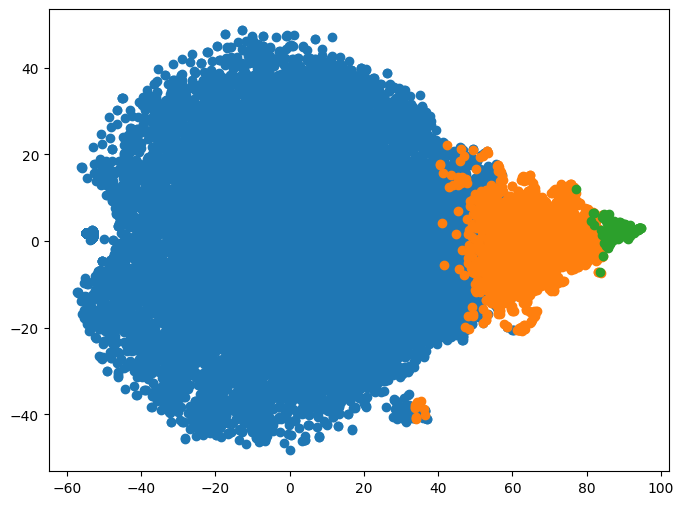

In [101]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.stats import norm

flattened_data = [neuron.left_right_equal for neuron in grouped_neurons]


X = np.array(flattened_data)

num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

cluster_labels_3 = kmeans.labels_


cluster_means = []
cluster_sds = []

for i in range(num_clusters):
    cluster_data = X[cluster_labels_3 == i]  # data points belonging to cluster i
    mean = np.mean(cluster_data)
    sd = np.std(cluster_data)
    cluster_means.append(mean)
    cluster_sds.append(sd)

tsne = TSNE(n_components=2, random_state=12)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(X_embedded[cluster_labels_3 == i, 0], X_embedded[cluster_labels_3 == i, 1], label=f'Cluster {i}')



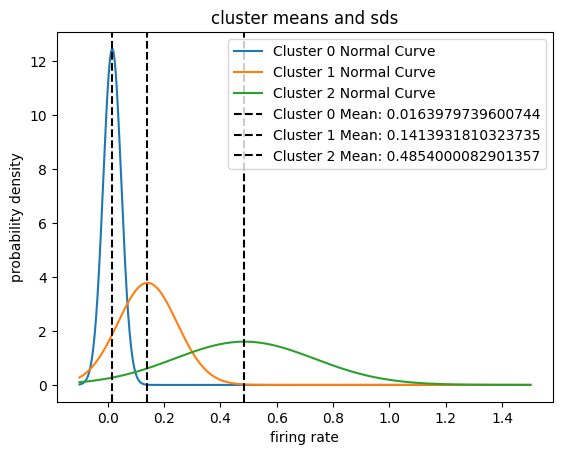

In [102]:

x_values = np.linspace(np.min(X)-.1, 1.5, 1000)
for i in range(num_clusters):
    plt.plot(x_values, norm.pdf(x_values, cluster_means[i], cluster_sds[i]), label=f'Cluster {i} Normal Curve')
for i in range(num_clusters):
  label_string = f'Cluster {i} Mean: ' + str(cluster_means[i])
  plt.axvline(x=cluster_means[i], color='black', linestyle='--', label=label_string)
plt.title('cluster means and sds')
plt.xlabel('firing rate')
plt.ylabel('probability density')
plt.legend()
plt.show()



To see the population density

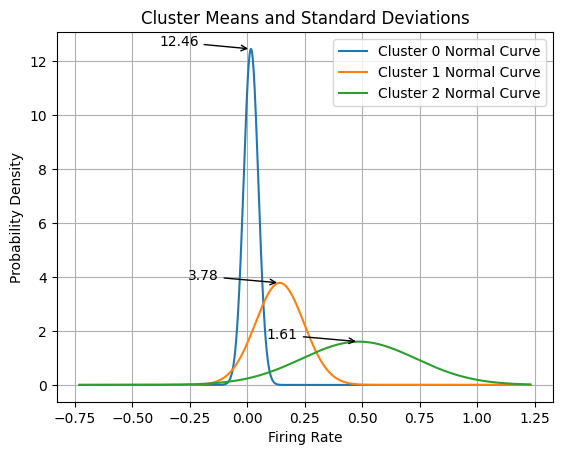

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm



x_values = np.linspace(np.min(cluster_means) - 3 * np.max(cluster_sds),
                       np.max(cluster_means) + 3 * np.max(cluster_sds), 1000)


for i in range(num_clusters):
    plt.plot(x_values, norm.pdf(x_values, cluster_means[i], cluster_sds[i]),
             label=f'Cluster {i} Normal Curve')


    peak_value = np.max(norm.pdf(x_values, cluster_means[i], cluster_sds[i]))
    peak_index = np.argmax(norm.pdf(x_values, cluster_means[i], cluster_sds[i]))
    peak_x = x_values[peak_index]


    plt.annotate(f'{peak_value:.2f}', xy=(peak_x, peak_value),
                 xytext=(peak_x - 0.4, peak_value + 0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('Cluster Means and Standard Deviations')
plt.xlabel('Firing Rate')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
print(len(grouped_neurons))
print(len(cluster_labels_3))
ones = 0
twos = 0
zeros = 0
for num in cluster_labels_3:
  if num == 1:
    ones+=1
  if num == 2:
    twos += 1
  if num == 0:
    zeros += 1
print(ones, twos, zeros)

14983
14983
1637 166 13180


one group only has a 166 neurons. This is very small so I will try with 2 clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


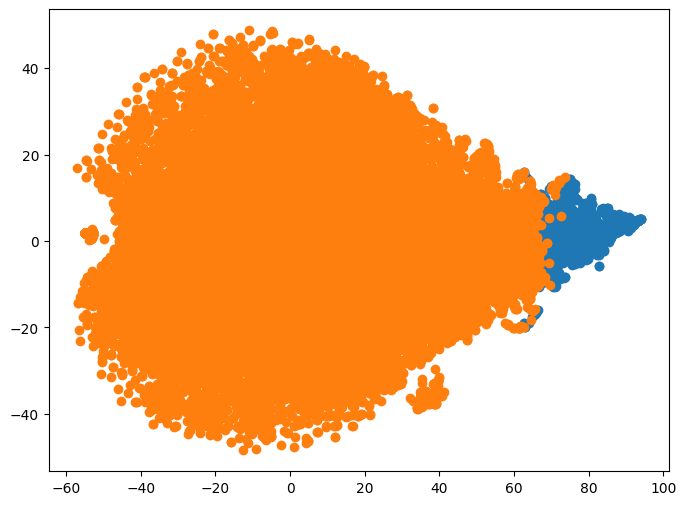

In [105]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.stats import norm

flattened_data = [neuron.left_right_equal for neuron in grouped_neurons]


X = np.array(flattened_data)

num_clusters = 2 # Ill try with 2

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

cluster_labels_2 = kmeans.labels_


cluster_means_2 = []
cluster_sds_2 = []

for i in range(num_clusters):
    cluster_data = X[cluster_labels_2 == i]
    mean = np.mean(cluster_data)
    sd = np.std(cluster_data)
    cluster_means_2.append(mean)
    cluster_sds_2.append(sd)


tsne = TSNE(n_components=2, random_state=182)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(X_embedded[cluster_labels_2 == i, 0], X_embedded[cluster_labels_2 == i, 1], label=f'Cluster {i}')

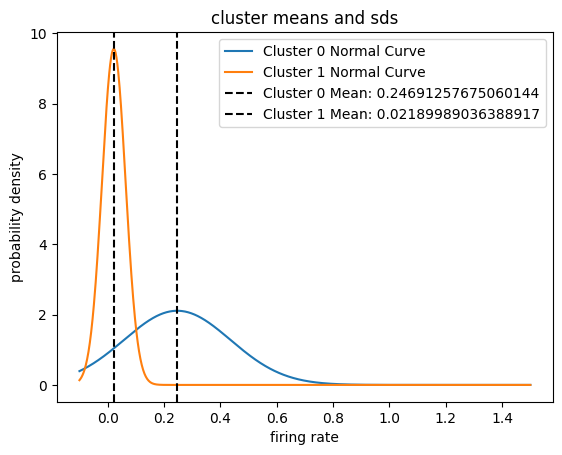

In [106]:
x_values = np.linspace(np.min(X)-.1, 1.5, 1000)
for i in range(num_clusters):
    plt.plot(x_values, norm.pdf(x_values, cluster_means_2[i], cluster_sds_2[i]), label=f'Cluster {i} Normal Curve')
for i in range(num_clusters):
  label_string = f'Cluster {i} Mean: ' + str(cluster_means_2[i])
  plt.axvline(x=cluster_means_2[i], color='black', linestyle='--', label=label_string)
plt.title('cluster means and sds')
plt.xlabel('firing rate')
plt.ylabel('probability density')
plt.legend()
plt.show()

In [107]:
zero = 0
one = 0


for cluster in cluster_labels_2:
    if cluster == 0:
        zero += 1
    elif cluster == 1:
        one += 1


print("Cluster Counts:")
print(f"Cluster 0: {zero}")
print(f"Cluster 1: {one}")
print(zero+one)
print(len(grouped_neurons))


Cluster Counts:
Cluster 0: 889
Cluster 1: 14094
14983
14983


I will use just 2 clusters due to small size

In [108]:
# now we need to figure out how we want to organize our training and testing data

for i in range(len(grouped_neurons)):
  if cluster_labels_2[i] == 1:
    print(i)
  grouped_neurons[i].set_cluster(cluster_labels_2[i])
  # we are using this function rather than just changing the value directly because this function will also change the cluster for all the neuron instances

Streaming output truncated to the last 5000 lines.
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632
9633
9634
9635
9636
9637
9638
9639
9640
9641
9642
9643
9644
9645
9646
9647
9648
9649
9650
9651
9652
9653
9654
9655
9656
9657
9658
9659
9660
9661
9662
9663
9664
9665
9666
9667
9668
9669
9670
9671
9672
9673
9674
9675
9680
9682
9683
9686
9687
9691
9692
9694
9696
9697
9699
9700
9701
9702
9704
9705
9706
9707
9708
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816

In [ ]:
len(grouped_neurons)

16199

In [109]:
for grouped_neuron in grouped_neurons:
  for neuron in grouped_neuron.neurons:
    if neuron.cluster != 0:
      print(neuron.mother.trial_id)
      if neuron.brain_area in unsignificant: #one last check
        print("ERROR ERROR", neuron.brain_area)
  # success! looks like there is one in every trial and session like I wanted

Streaming output truncated to the last 5000 lines.
sesh18_16
sesh18_17
sesh18_18
sesh18_19
sesh18_20
sesh18_21
sesh18_22
sesh18_23
sesh18_24
sesh18_25
sesh18_26
sesh18_27
sesh18_28
sesh18_29
sesh18_30
sesh18_31
sesh18_32
sesh18_33
sesh18_34
sesh18_35
sesh18_36
sesh18_37
sesh18_38
sesh18_39
sesh18_40
sesh18_41
sesh18_42
sesh18_43
sesh18_44
sesh18_45
sesh18_46
sesh18_47
sesh18_48
sesh18_49
sesh18_50
sesh18_51
sesh18_52
sesh18_53
sesh18_54
sesh18_55
sesh18_56
sesh18_57
sesh18_58
sesh18_59
sesh18_60
sesh18_61
sesh18_62
sesh18_63
sesh18_64
sesh18_65
sesh18_66
sesh18_67
sesh18_68
sesh18_69
sesh18_70
sesh18_71
sesh18_72
sesh18_73
sesh18_74
sesh18_75
sesh18_76
sesh18_77
sesh18_78
sesh18_79
sesh18_80
sesh18_81
sesh18_82
sesh18_83
sesh18_84
sesh18_85
sesh18_86
sesh18_87
sesh18_88
sesh18_89
sesh18_90
sesh18_91
sesh18_92
sesh18_93
sesh18_94
sesh18_95
sesh18_96
sesh18_97
sesh18_98
sesh18_99
sesh18_100
sesh18_101
sesh18_102
sesh18_103
sesh18_104
sesh18_105
sesh18_106
sesh18_107
sesh18_108
sesh18_109

In [110]:
names_total = [] # I want to get all the trial id names. I will take a set of these later to get rid of all the dups
for grouped_neuron in grouped_neurons:
  for neuron in grouped_neuron.neurons:
    names_total.append(neuron.mother.trial_id)
unique_names = list(set(names_total))

print(unique_names)
print(len(unique_names)) # this will be how many rows we have in the dataframe. Not many, but enough. Training will be fast

['sesh12_94', 'sesh13_65', 'sesh10_34', 'sesh1_62', 'sesh5_91', 'sesh1_61', 'sesh3_94', 'sesh9_3', 'sesh14_110', 'sesh6_101', 'sesh12_63', 'sesh8_109', 'sesh11_113', 'sesh2_100', 'sesh16_31', 'sesh3_37', 'sesh2_112', 'sesh4_14', 'sesh13_15', 'sesh14_57', 'sesh11_107', 'sesh16_95', 'sesh7_86', 'sesh12_113', 'sesh16_103', 'sesh4_9', 'sesh18_105', 'sesh12_45', 'sesh6_96', 'sesh8_33', 'sesh12_43', 'sesh10_65', 'sesh11_48', 'sesh7_47', 'sesh16_101', 'sesh15_19', 'sesh7_69', 'sesh15_44', 'sesh5_56', 'sesh5_18', 'sesh11_38', 'sesh8_14', 'sesh10_78', 'sesh18_43', 'sesh11_42', 'sesh1_11', 'sesh6_113', 'sesh2_54', 'sesh2_23', 'sesh6_2', 'sesh8_29', 'sesh11_45', 'sesh4_91', 'sesh15_66', 'sesh3_1', 'sesh8_32', 'sesh7_105', 'sesh3_34', 'sesh7_18', 'sesh5_98', 'sesh13_10', 'sesh17_34', 'sesh3_75', 'sesh14_38', 'sesh4_43', 'sesh9_50', 'sesh12_77', 'sesh10_16', 'sesh9_95', 'sesh2_67', 'sesh1_101', 'sesh18_40', 'sesh1_85', 'sesh1_9', 'sesh4_28', 'sesh9_56', 'sesh13_91', 'sesh6_98', 'sesh15_16', 'sesh10

In [111]:
# yet another class. I can't help myself XD
class trial_row_class():
  def __init__(self):
  #stuff that will actually be used in df
    self.name = None
    self.cluster0_avg_half1 = None # the average firing of the cluster 0 neurons in the first half of the time interval
    self.cluster1_avg_half1 = None # the average firing of the cluster 1 neurons in the first half of the time interval

    self.cluster0_avg_half2 = None # the average firing of the cluster 0 neurons in the second half of the time interval
    self.cluster1_avg_half2 = None # the average firing of the cluster 1 neurons in the second half of the time interval

    self.right = None # one hot encoding the results. this will be 1 or 0
    self.left = None
    self.equal = None

  # stuff that will help us construct the df
    self.cluster0_neurons = [] # the actual neurons
    self.cluster1_neurons = []


  # this is a private helper function that is only accessiable within the class
  def __get_averages(self, cluster_neurons):
        temp_first = []
        temp_second = []
        for neuron in cluster_neurons:
            if len(neuron.data) != 40:
                raise ValueError("something unexpected occured! Neuron.data length should be 40. Instead its " + str(len(neuron.data)))
            else:
                temp_first.append(np.mean(neuron.data[:20]))
                temp_second.append(np.mean(neuron.data[20:]))

        if not (len(temp_first) == len(cluster_neurons) and len(temp_second) == len(cluster_neurons)):
            raise ValueError("we must have calculated the means wrong cause the lists are not equal: " + str(len(cluster_neurons)) + " " + str(len(temp_first))+ " " + str(len(temp_second)))
        else:
            return np.mean(temp_first), np.mean(temp_second)


  def __check_result(self): # to check our result to make sure the neurons all have the same result
    total_neurons = self.cluster0_neurons + self.cluster1_neurons
    kinds = [neuron.kind for neuron in total_neurons]
    if len(list(set(kinds))) != 1: #they should all be the same element
      raise ValueError("Not all neurons are of the same kind" + str(kinds))
    else:
      return True
    # to averages once we have neuron data
  def set_averages(self):
     self.cluster0_avg_half1, self.cluster0_avg_half2 =  self.__get_averages(self.cluster0_neurons)
     self.cluster1_avg_half1, self.cluster1_avg_half2 =  self.__get_averages(self.cluster1_neurons)

  def set_result(self):
    if self.__check_result():
      if self.cluster0_neurons[0].kind == "left true":
        self.left = 1
        self.right = 0
        self.equal = 0
      elif self.cluster0_neurons[0].kind == "right true":
        self.left = 0
        self.right = 1
        self.equal = 0
      elif self.cluster0_neurons[0].kind == "equal true":
        self.left = 0
        self.right = 0
        self.equal = 1
      else:
        raise ValueError(self.cluster0_neurons[0].kind)







In [112]:
trial_rows = {}
for name in unique_names:
  temp = trial_row_class()
  temp.name = name
  trial_rows[name] = temp


In [113]:
trial_rows

{'sesh12_94': <__main__.trial_row_class at 0x789efa5d4b20>,
 'sesh13_65': <__main__.trial_row_class at 0x789efa5d5a50>,
 'sesh10_34': <__main__.trial_row_class at 0x789efa5d6470>,
 'sesh1_62': <__main__.trial_row_class at 0x789efa5d5ab0>,
 'sesh5_91': <__main__.trial_row_class at 0x789efa5d5f90>,
 'sesh1_61': <__main__.trial_row_class at 0x789efa5d71f0>,
 'sesh3_94': <__main__.trial_row_class at 0x789efa5d7280>,
 'sesh9_3': <__main__.trial_row_class at 0x789efa5d4af0>,
 'sesh14_110': <__main__.trial_row_class at 0x789efa5d4940>,
 'sesh6_101': <__main__.trial_row_class at 0x789efa5d6350>,
 'sesh12_63': <__main__.trial_row_class at 0x789efa5d5450>,
 'sesh8_109': <__main__.trial_row_class at 0x789efa5d5ff0>,
 'sesh11_113': <__main__.trial_row_class at 0x789efa5d66b0>,
 'sesh2_100': <__main__.trial_row_class at 0x789efa5d6500>,
 'sesh16_31': <__main__.trial_row_class at 0x789efa5d6b90>,
 'sesh3_37': <__main__.trial_row_class at 0x789efa5d73d0>,
 'sesh2_112': <__main__.trial_row_class at 0x

In [114]:
string = "right true"
string[-4:]

'true'

In [115]:
for grouped_neuron in grouped_neurons:
  for neuron in grouped_neuron.neurons:
        if neuron.kind[-4:] != 'true': # this will not contain any data we want
          try:
            del trial_rows[neuron.mother.trial_id]
          except: # means we already deleted it
            continue
        else:
          if neuron.cluster == 0:
            trial_rows[neuron.mother.trial_id].cluster0_neurons.append(neuron) # we know this neuron belongs to this row
          elif neuron.cluster == 1:
            trial_rows[neuron.mother.trial_id].cluster1_neurons.append(neuron)



In [116]:
print(len(trial_rows))

1822


In [117]:
for key in trial_rows:

  if len(trial_rows[key].cluster0_neurons) == 0 or len(trial_rows[key].cluster1_neurons) == 0 :
    print("ladies and gentlemen, we have a 0")
# nice!

In [118]:
for key in trial_rows:
  trial_rows[key].set_averages()
  trial_rows[key].set_result()

In [119]:
print(trial_rows['sesh10_11'].right, trial_rows['sesh10_11'].left, trial_rows['sesh10_11'].equal, trial_rows['sesh10_11'].cluster0_avg_half1, trial_rows['sesh10_11'].cluster0_avg_half2, trial_rows['sesh10_11'].cluster1_avg_half1, trial_rows['sesh10_11'].cluster1_avg_half2)


0 0 1 0.2815217391304347 0.31413043478260866 0.0178494623655914 0.018118279569892475


In [120]:
# NICE

In [121]:
cluster0_half1 = []
cluster0_half2 = []
cluster1_half1 = []
cluster1_half2 = []
# the results are one hot encoded
left = []
right = []
equal = []
names = []
for trial_row_key in trial_rows:
  cluster0_half1.append(trial_rows[trial_row_key].cluster0_avg_half1)
  cluster0_half2.append(trial_rows[trial_row_key].cluster0_avg_half2)

  cluster1_half1.append(trial_rows[trial_row_key].cluster1_avg_half1)
  cluster1_half2.append(trial_rows[trial_row_key].cluster1_avg_half2)

  left.append(trial_rows[trial_row_key].left)
  right.append(trial_rows[trial_row_key].right)
  equal.append(trial_rows[trial_row_key].equal)

  names.append(trial_row_key)


In [122]:
# FINALLY MAKING A DATAFRAME
trial_data = pd.DataFrame({
    'names': names,
    'cluster0_half1': cluster0_half1,
    'cluster0_half2': cluster0_half2,
    'cluster1_half1': cluster1_half1,
    'cluster1_half2': cluster1_half2,
    'left': left,
    'right': right,
    'equal': equal,
})

In [123]:
trial_data.to_csv('trial_data.csv', index=False)

In [128]:
from sklearn.preprocessing import MinMaxScaler

# I am scaling these together because the test set will have a small sample size then I am usually comfortable with and I don't want to affect the way it is scaled
columns_to_scale = ['cluster0_half1', 'cluster0_half2', 'cluster1_half1', 'cluster1_half2']
scaler = MinMaxScaler()
trial_data[columns_to_scale] = scaler.fit_transform(trial_data[columns_to_scale])
print(trial_data)

           names  cluster0_half1  cluster0_half2  cluster1_half1  \
0      sesh12_94        0.311431        0.316619        0.391128   
1      sesh13_65        0.417364        0.490077        0.635828   
2      sesh10_34        0.466363        0.599223        0.190036   
3       sesh1_62        0.195685        0.307104        0.309568   
4       sesh5_91        0.738950        0.730983        0.425835   
...          ...             ...             ...             ...   
1817   sesh12_39        0.216363        0.355498        0.300225   
1818  sesh13_110        0.517272        0.573019        0.499263   
1819  sesh15_105        0.283715        0.330436        0.412529   
1820   sesh18_31        0.211349        0.458206        0.214324   
1821   sesh12_64        0.298318        0.168172        0.376330   

      cluster1_half2  left  right  equal  
0           0.356607     0      0      1  
1           0.452432     0      0      1  
2           0.290703     1      0      0  
3          

In [150]:
trial_data

names  cluster0_half1  cluster0_half2  cluster1_half1  \
0      sesh12_94        0.311431        0.316619        0.391128   
1      sesh13_65        0.417364        0.490077        0.635828   
2      sesh10_34        0.466363        0.599223        0.190036   
3       sesh1_62        0.195685        0.307104        0.309568   
4       sesh5_91        0.738950        0.730983        0.425835   
...          ...             ...             ...             ...   
1817   sesh12_39        0.216363        0.355498        0.300225   
1818  sesh13_110        0.517272        0.573019        0.499263   
1819  sesh15_105        0.283715        0.330436        0.412529   
1820   sesh18_31        0.211349        0.458206        0.214324   
1821   sesh12_64        0.298318        0.168172        0.376330   

      cluster1_half2  left  right  equal  
0           0.356607     0      0      1  
1           0.452432     0      0      1  
2           0.290703     1      0      0  
3           0.403067     0      0      1  
4           0.496021     0      1      0  
...              ...   ...    ...    ...  
1817        0.330690     1      0      0  
1818        0.527886     0      1      0  
1819        0.492227     0      0      1  
1820        0.264202     1      0      0  
1821        0.199252     0      0      1  

[1822 rows x 8 columns]

In [151]:
num_rows_right = (trial_data['right'] == 1).sum()

print("Number of rows where 'right' equals 1:", num_rows_right)

num_rows_left = (trial_data['left'] == 1).sum()

print("Number of rows where 'left' equals 1:", num_rows_left)

num_rows_equal = (trial_data['equal'] == 1).sum()

print("Number of rows where 'equal' equals 1:", num_rows_equal)

# roughly even

Number of rows where 'right' equals 1: 518
Number of rows where 'left' equals 1: 547
Number of rows where 'equal' equals 1: 757


Note: i accidently deleted this cell, but when I tried to train a model on this data, my model was overwhelmingly choosing 'equal' due to the fact it was overrepresented in the training data. To remedy this, I am ensuring all classes are represented an equal number of times

In [152]:
equal_data = trial_data[trial_data['equal'] == 1]
left_data = trial_data[trial_data['left'] == 1]
right_data = trial_data[trial_data['right'] == 1]

equal_sample = equal_data.sample(n=518, random_state=12)
left_sample = left_data.sample(n=518, random_state=12)
right_sample = right_data.sample(n=518, random_state=12)


subset_data = pd.concat([equal_sample, left_sample, right_sample], ignore_index=True)


subset_data = subset_data.sample(frac=1, random_state=12).reset_index(drop=True)


print(subset_data)

           names  cluster0_half1  cluster0_half2  cluster1_half1  \
0      sesh17_41        0.122085        0.237277        0.206009   
1       sesh8_66        0.239453        0.140665        0.522766   
2     sesh16_101        0.255701        0.228258        0.472689   
3       sesh9_24        0.231891        0.476414        0.360915   
4      sesh17_31        0.331892        0.377680        0.388225   
...          ...             ...             ...             ...   
1549    sesh6_80        0.238793        0.333548        0.050946   
1550   sesh18_29        0.347106        0.414961        0.411494   
1551    sesh2_30        0.323451        0.317798        0.489706   
1552    sesh5_80        0.587766        0.711024        0.288360   
1553    sesh2_41        0.325637        0.346073        0.482060   

      cluster1_half2  left  right  equal  
0           0.211133     0      0      1  
1           0.353878     0      0      1  
2           0.583413     0      1      0  
3          

In [161]:
subset_data.to_csv('/content/subset_data_final.csv', index=False)

<ipython-input-154-e24ca9f881c2>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = subset_data.corr()


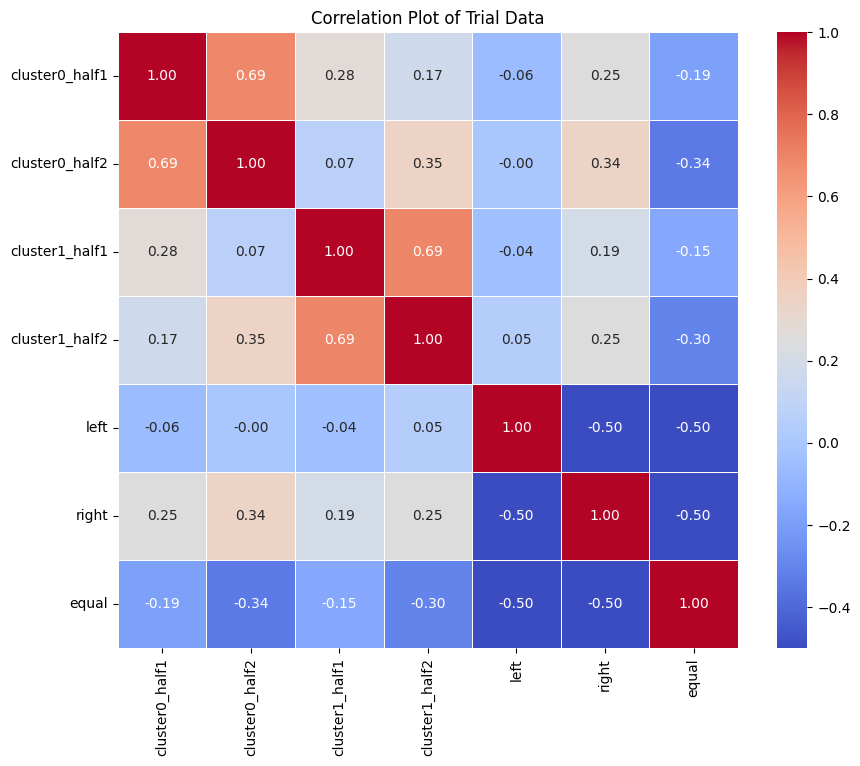

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = subset_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot of Trial Data')
plt.show()

In [ ]:
# looking at the plot, it seems like none of our data is very good at predicting left

In [156]:
from sklearn.model_selection import train_test_split

X_train = subset_data.drop(columns=['left', 'right', 'equal', 'names'])
y_train = subset_data[['left', 'right', 'equal']]


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (1554, 4)
y_train shape: (1554, 3)


fold number 1/5
Epoch 1/200
38/39 [============================>.] - ETA: 0s - loss: 1.0851 - accuracy: 0.3898
Epoch 1: val_accuracy improved from -inf to 0.49032, saving model to best_model_fold.h5
39/39 [==============================] - 4s 44ms/step - loss: 1.0851 - accuracy: 0.3886 - val_loss: 1.0487 - val_accuracy: 0.4903
Epoch 2/200
 1/39 [..............................] - ETA: 1s - loss: 1.0417 - accuracy: 0.4375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - ETA: 0s - loss: 1.0192 - accuracy: 0.4763
Epoch 2: val_accuracy improved from 0.49032 to 0.51613, saving model to best_model_fold.h5
39/39 [==============================] - 1s 26ms/step - loss: 1.0192 - accuracy: 0.4763 - val_loss: 1.0027 - val_accuracy: 0.5161
Epoch 3/200
37/39 [===========================>..] - ETA: 0s - loss: 1.0133 - accuracy: 0.4840
Epoch 3: val_accuracy did not improve from 0.51613
39/39 [==============================] - 1s 20ms/step - loss: 1.0169 - accuracy: 0.4787 - val_loss: 0.9968 - val_accuracy: 0.5161
Epoch 4/200
37/39 [===========================>..] - ETA: 0s - loss: 1.0053 - accuracy: 0.4772
Epoch 4: val_accuracy did not improve from 0.51613
39/39 [==============================] - 1s 20ms/step - loss: 1.0088 - accuracy: 0.4739 - val_loss: 1.0054 - val_accuracy: 0.5161
Epoch 5/200
38/39 [============================>.] - ETA: 0s - loss: 1.0021 - accuracy: 0.4910
Epoch 5: val_accuracy improved from 0.51613 to 0.

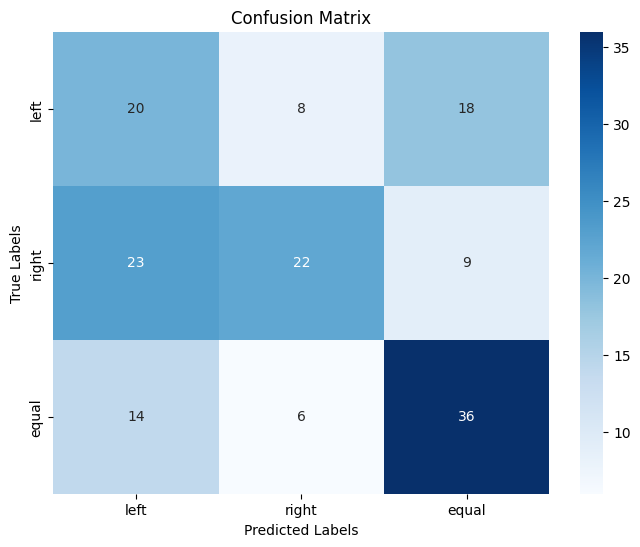

fold number 2/5
Epoch 1/200
38/39 [============================>.] - ETA: 0s - loss: 1.0881 - accuracy: 0.3808
Epoch 1: val_accuracy did not improve from 0.61290
39/39 [==============================] - 3s 30ms/step - loss: 1.0886 - accuracy: 0.3797 - val_loss: 1.0542 - val_accuracy: 0.4258
Epoch 2/200
37/39 [===========================>..] - ETA: 0s - loss: 1.0403 - accuracy: 0.4468
Epoch 2: val_accuracy did not improve from 0.61290
39/39 [==============================] - 1s 19ms/step - loss: 1.0356 - accuracy: 0.4553 - val_loss: 1.0073 - val_accuracy: 0.4710
Epoch 3/200
36/39 [==========================>...] - ETA: 0s - loss: 1.0244 - accuracy: 0.4705
Epoch 3: val_accuracy did not improve from 0.61290
39/39 [==============================] - 1s 21ms/step - loss: 1.0207 - accuracy: 0.4706 - val_loss: 0.9924 - val_accuracy: 0.4387
Epoch 4/200
39/39 [==============================] - ETA: 0s - loss: 1.0062 - accuracy: 0.4795
Epoch 4: val_accuracy did not improve from 0.61290
39/39 [===

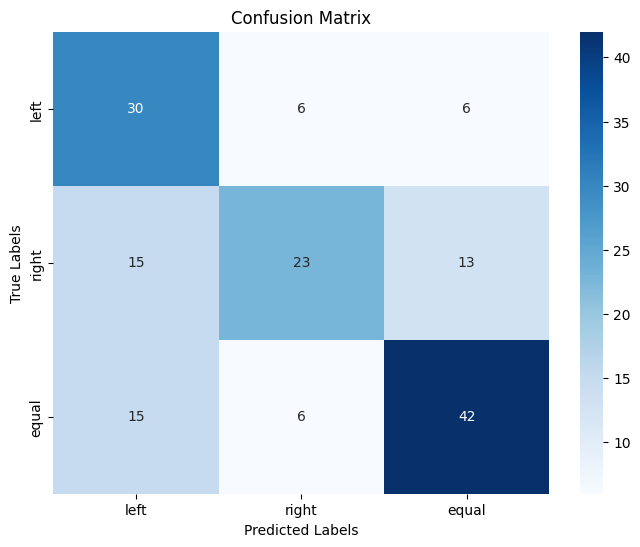

fold number 3/5
Epoch 1/200
38/39 [============================>.] - ETA: 0s - loss: 1.0849 - accuracy: 0.4161
Epoch 1: val_accuracy did not improve from 0.61290
39/39 [==============================] - 3s 34ms/step - loss: 1.0842 - accuracy: 0.4167 - val_loss: 1.0197 - val_accuracy: 0.4581
Epoch 2/200
37/39 [===========================>..] - ETA: 0s - loss: 1.0103 - accuracy: 0.4865
Epoch 2: val_accuracy did not improve from 0.61290
39/39 [==============================] - 1s 21ms/step - loss: 1.0110 - accuracy: 0.4835 - val_loss: 0.9895 - val_accuracy: 0.4968
Epoch 3/200
37/39 [===========================>..] - ETA: 0s - loss: 1.0073 - accuracy: 0.4747
Epoch 3: val_accuracy did not improve from 0.61290
39/39 [==============================] - 1s 19ms/step - loss: 1.0049 - accuracy: 0.4787 - val_loss: 0.9689 - val_accuracy: 0.5419
Epoch 4/200
37/39 [===========================>..] - ETA: 0s - loss: 1.0048 - accuracy: 0.4941
Epoch 4: val_accuracy did not improve from 0.61290
39/39 [===

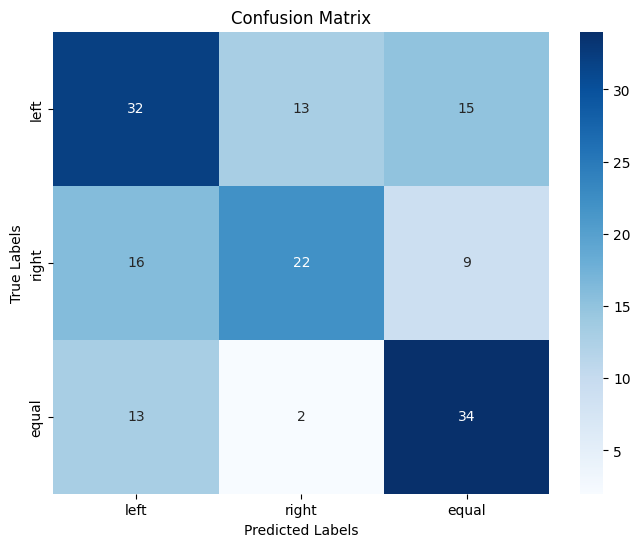

fold number 4/5
Epoch 1/200
37/39 [===========================>..] - ETA: 0s - loss: 1.0888 - accuracy: 0.3725
Epoch 1: val_accuracy did not improve from 0.61290
39/39 [==============================] - 2s 26ms/step - loss: 1.0871 - accuracy: 0.3789 - val_loss: 1.0633 - val_accuracy: 0.4000
Epoch 2/200
37/39 [===========================>..] - ETA: 0s - loss: 1.0281 - accuracy: 0.4535
Epoch 2: val_accuracy did not improve from 0.61290
39/39 [==============================] - 1s 21ms/step - loss: 1.0261 - accuracy: 0.4529 - val_loss: 1.0658 - val_accuracy: 0.4194
Epoch 3/200
39/39 [==============================] - ETA: 0s - loss: 1.0050 - accuracy: 0.4851
Epoch 3: val_accuracy did not improve from 0.61290
39/39 [==============================] - 1s 31ms/step - loss: 1.0050 - accuracy: 0.4851 - val_loss: 1.0333 - val_accuracy: 0.4516
Epoch 4/200
39/39 [==============================] - ETA: 0s - loss: 0.9966 - accuracy: 0.5004
Epoch 4: val_accuracy did not improve from 0.61290
39/39 [===

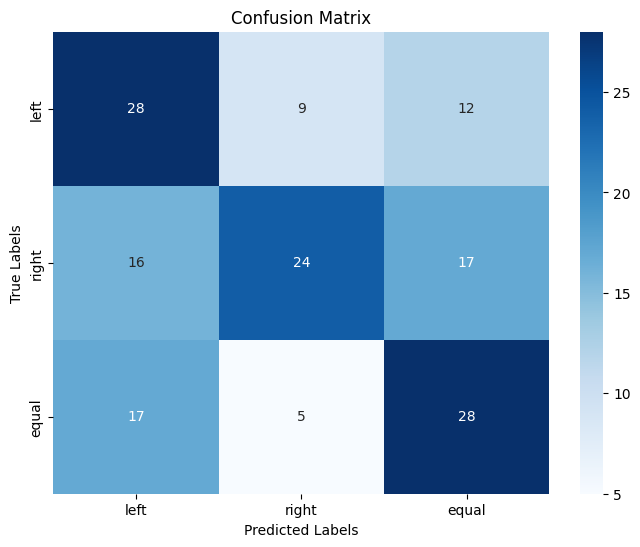

fold number 5/5
Epoch 1/200
39/39 [==============================] - ETA: 0s - loss: 1.0868 - accuracy: 0.3738
Epoch 1: val_accuracy did not improve from 0.61290
39/39 [==============================] - 2s 28ms/step - loss: 1.0868 - accuracy: 0.3738 - val_loss: 1.0395 - val_accuracy: 0.4387
Epoch 2/200
39/39 [==============================] - ETA: 0s - loss: 1.0087 - accuracy: 0.4799
Epoch 2: val_accuracy did not improve from 0.61290
39/39 [==============================] - 1s 32ms/step - loss: 1.0087 - accuracy: 0.4799 - val_loss: 1.0415 - val_accuracy: 0.4581
Epoch 3/200
39/39 [==============================] - ETA: 0s - loss: 0.9995 - accuracy: 0.4863
Epoch 3: val_accuracy did not improve from 0.61290
39/39 [==============================] - 1s 33ms/step - loss: 0.9995 - accuracy: 0.4863 - val_loss: 1.0408 - val_accuracy: 0.4452
Epoch 4/200
39/39 [==============================] - ETA: 0s - loss: 0.9941 - accuracy: 0.4968
Epoch 4: val_accuracy did not improve from 0.61290
39/39 [===

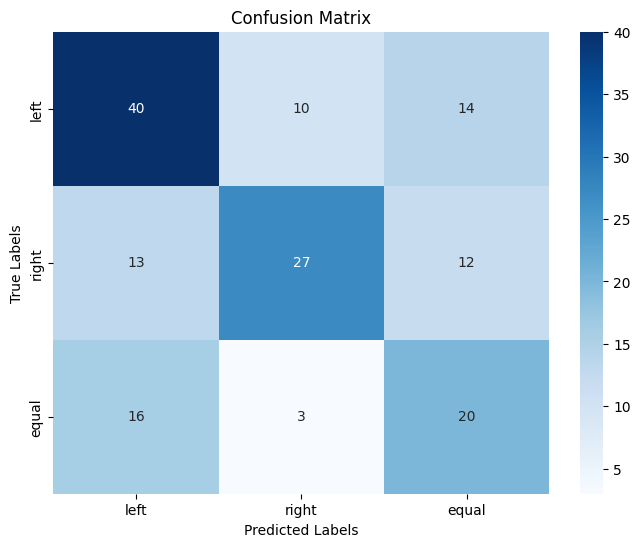

In [158]:
# using k folds because we have limited data so we want to use it all
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold, train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

num_folds = 5


kf = KFold(n_splits=num_folds, shuffle=True)
callbacks = [ModelCheckpoint("best_model_fold.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
             EarlyStopping(monitor='val_accuracy', patience=50, verbose=1, mode='max', restore_best_weights=True)]

all_histories = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"fold number {fold_idx + 1}/{num_folds}")

    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # we will use half the val data for testing
    X_val_fold, X_test_fold, y_val_fold, y_test_fold = train_test_split(X_val_fold, y_val_fold, test_size=0.5, random_state=12)


    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(4096, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(3, activation='softmax') # three output neurons to account for the 3 categories we are trying to predict
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    history = model.fit(X_train_fold, y_train_fold,
                        epochs=200,
                        batch_size=32,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=callbacks)

    best_model = load_model("best_model_fold.h5") # get the model the preformed best on the validation data for each fold
    test_loss, test_acc = best_model.evaluate(X_test_fold, y_test_fold)
    print("Test accuracy:", test_acc)
    y_pred__prob = best_model.predict(X_test_fold)
    y_true_matrix = np.matrix(y_test_fold)
    y_true = np.argmax(np.asarray(y_true_matrix), axis=1)
    y_pred_list = np.argmax(y_pred__prob, axis = 1)
    cm = confusion_matrix(y_true, y_pred_list)
    class_labels = ['left', 'right', 'equal']


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    all_histories.append(history)





In [160]:
# I forgot to make the different testing accuracies for each of the fold into lists, but if I do it based on what was printed:

# filling these in in reverse order of the folds. see output from previous code to verify
kfolds_tests = [0.5612903237342834, 0.5128205418586731, 0.5641025900840759, 0.6089743375778198, 0.5]
average_testing_accuracy = sum(kfolds_tests)/5
print(average_testing_accuracy)

print('highest k fold testing accuracy', max(kfolds_tests))
print('lowset k fold testing accuracy', min(kfolds_tests))

0.5494375586509704
highest k fold testing accuracy 0.6089743375778198
lowset k fold testing accuracy 0.5


Some observations from the matrices, it seems like the it had a harder time determining left from right than it did identifying equal. This makes sense because on ur correlation matrix, left wasn't really correlated to any of our predictors